
Makes a 4-panel plot from my chosen best dates for histogram, or hist by area.

0.      For PAD and YF: choose inner ROI
1.    Choose best dates (in notebook) or multi-temporal hist
2.      Seed with CIR maks lakes (to help YF)
3.      Histograms of EM% binned by AREA

TODO: 
* Plots for all regions aggregated X
* Use GW fraction not EM fraction?
* "n=##" in titles X
* How to do error bars on log-log plots???


In [1]:
## imports
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
from python_env import *
from scipy import stats
# from scipy.stats import bootstrap
# from memory_profiler import profile

In [2]:
## User vars
min_size=250 # meters squared
regions=['Daring','Baker','PAD','YFLATS']

## constants
region_labels=dict(zip(
    [
    'daring_21405_17063_010_170614_L090_CX_01_LUT-Freeman_rcls_lakes.shp',
    'daring_21405_17094_010_170909_L090_CX_01_LUT-Freeman_rcls_lakes.shp',
    'bakerc_16008_18047_005_180821_L090_CX_02_Freeman-inc_rcls_lakes.shp',
    'bakerc_16008_19059_012_190904_L090_CX_01_Freeman-inc_rcls_lakes.shp',
    'PAD_170613_mosaic_rcls_lakes.shp',
    'PAD_170908_mosaic_rcls_lakes.shp',
    'PAD_180821_mosaic_rcls_lakes.shp',
    'padelE_36000_19059_003_190904_L090_CX_01_Freeman-inc_rcls_lakes.shp',
    'YFLATS_170621_mosaic_rcls_lakes.shp',
    'YFLATS_170916_mosaic_rcls_lakes.shp',
    'YFLATS_180827_mosaic_rcls_lakes.shp',
    'YFLATS_190914_mosaic_rcls_lakes.shp'
    ],

    [
    'CSD June 2017',
    'CSD Sept 2017',
    'CSB Aug 2018',
    'CSB Sept 2019',
    'PAD June 2017',
    'PAD September 2017',
    'PAD Aug 2018',
    'PAD Sept 2019',
    'YF June 2017',
    'YF Sept 2017',
    'YF Aug 2018',
    'YF Sept 2019'
    ]
))
best_dates=[
    'YFLATS_180827_mosaic_rcls_lakes.shp', 'padelE_36000_19059_003_190904_L090_CX_01_Freeman-inc_rcls_lakes.shp', 'daring_21405_17094_010_170909_L090_CX_01_LUT-Freeman_rcls_lakes.shp', 'bakerc_16008_18047_005_180821_L090_CX_02_Freeman-inc_rcls_lakes.shp'
            ]
## load data
plt.style.use('/mnt/d/Dropbox/Python/Matplotlib-rcParams/presentation.mplstyle')

## for error bars
error_kw = {'capsize': 3.5, 'capthick': 1.5, 'ecolor': 'black', 'elinewidth': 1.5, 'alpha':0.6}

In [3]:
# dynamic I/O
## Save directory for dataframes as excel file
output_excel_dir = os.path.join(output_raster_dir_common_roi, 'combined_excel')
os.makedirs(output_excel_dir, exist_ok=True)
excel_pth_best_dates = os.path.join(output_raster_dir_common_roi, 'combined_excel', 'lake-based-stats-best-dates.xlsx')
excel_pth_all_12 = os.path.join(output_raster_dir_common_roi, 'combined_excel', 'lake-based-stats-all-12.xlsx')
excel_pth_all_12_summary = os.path.join(output_raster_dir_common_roi, 'combined_excel', 'lake-based-stats-all-12-summary.xlsx')
excel_pth_all_lakes_all_times_full_roi = os.path.join(output_excel_dir, 'stats_all_lakes_all_times_full_roi.xlsx')

In [4]:
## Bootstrap functions
# modified from https://github.com/SUN-Wenjun/bootstrapping/blob/master/bootstrapping.py

def bootstrap_ci(df, variable, weight=None, repetitions = 1000, alpha = 0.05, random_state=None): # HERE 10000
    '''df: a data frame that includes observations of the two sample
    variable: the column name of the column that includes observations
    weight: variable name used for weighting (e.g. lake area)
    repetitions: number of times you want the bootstrapping to repeat. Default is 1000.
    alpha: likelihood that the true population parameter lies outside the confidence interval. Default is 0.05. 
    random_stata: enable users to set their own random_state, default is None.'''
    
    if weight != None:
        df = df.loc[:, [variable, weight]]
#         df_weights=df[weight]
    else: 
        df = df.loc[:, [variable]]
    
    bootstrap_sample_size = len(df) 

    means = []
    weight_means = [] # for weighted means

    for i in range(repetitions):
        bootstrap_sample = df.sample(n = bootstrap_sample_size, replace = True, random_state = random_state)
        
        ## mean
        mean = bootstrap_sample[variable].mean()
        means.append(mean)
        
        # weighted mean
        if weight != None:
            weight_mean = np.average(bootstrap_sample[variable], weights=bootstrap_sample[weight])
            weight_means.append(weight_mean)

    # confidence interval, mean and sem
    mn_left = np.percentile(means, alpha/2*100)
    mn_right = np.percentile(means, 100-alpha/2*100)   
    bs_mean=np.mean(means)
    bs_sem = np.std(means)
    
    if weight != None:
        wt_mn_left = np.percentile(weight_means, alpha/2*100)
        wt_mn_right = np.percentile(weight_means, 100-alpha/2*100)   
        bs_wt_mean=np.mean(weight_means)
        bs_wt_sem = np.std(weight_means)
    else:
        wt_mn_left, wt_mn_right, bs_wt_mean, bs_wt_sem = [np.nan]*4
    
    return bs_mean, mn_left, mn_right, bs_sem, bs_wt_mean, wt_mn_left, wt_mn_right, bs_wt_sem

In [5]:
## loop over 4 best dates
lakes_list=[]
lakes_labels=[]
for i, basename in enumerate(best_dates):
    ## dynamic I/O
    filename = os.path.join(shape_dir, basename)
    label = region_labels[basename]
    print('label: '+label)

    ## print
    print(f'\n\n----------------\nInput: {filename}')
    print(f'\t(File {i+1} of {len(best_dates)})\n')

    ## I/O
    lakes = gpd.read_file(filename)
    
    ## compute EM coverage m2
    lakes['em_coverage_m2'] = lakes.area_px_m2 * lakes.em_fractio
    
    ## region
    lakes['region'] = label

    ## filter
    filter=(lakes.edge==False) & (lakes.area_px_m2>=min_size) & (lakes.cir_observ==True)
    
    ## save to mem
    lakes_list.append(lakes[filter])
    lakes_labels.append(label)

label: YF Aug 2018


----------------
Input: /mnt/f/PAD2019/classification_training/PixelClassifier/Final-ORNL-DAAC/shp_no_rivers_no_smoothing/YFLATS_180827_mosaic_rcls_lakes.shp
	(File 1 of 4)

label: PAD Sept 2019


----------------
Input: /mnt/f/PAD2019/classification_training/PixelClassifier/Final-ORNL-DAAC/shp_no_rivers_no_smoothing/padelE_36000_19059_003_190904_L090_CX_01_Freeman-inc_rcls_lakes.shp
	(File 2 of 4)

label: CSD Sept 2017


----------------
Input: /mnt/f/PAD2019/classification_training/PixelClassifier/Final-ORNL-DAAC/shp_no_rivers_no_smoothing/daring_21405_17094_010_170909_L090_CX_01_LUT-Freeman_rcls_lakes.shp
	(File 3 of 4)

label: CSB Aug 2018


----------------
Input: /mnt/f/PAD2019/classification_training/PixelClassifier/Final-ORNL-DAAC/shp_no_rivers_no_smoothing/bakerc_16008_18047_005_180821_L090_CX_02_Freeman-inc_rcls_lakes.shp
	(File 4 of 4)



In [6]:
## loop over all 12 acquisitions (all available data)
lakes_list_all12=[]
lakes_labels_all12=[]
for i, basename in enumerate(region_labels.keys()):
    ## dynamic I/O
    filename = os.path.join(shape_dir, basename)
    label = region_labels[basename]
    print('label: '+label)

    ## print
    print(f'\n\n----------------\nInput: {filename}')
    print(f'\t(File {i+1} of {len(best_dates)})\n')

    ## I/O
    lakes = gpd.read_file(filename)

    ## filter
    filter=(lakes.edge==False) & (lakes.area_px_m2>=min_size) & (lakes.cir_observ==True)
    
    ## save to mem
    lakes_list_all12.append(lakes[filter])
    lakes_labels_all12.append(label)

label: CSD June 2017


----------------
Input: /mnt/f/PAD2019/classification_training/PixelClassifier/Final-ORNL-DAAC/shp_no_rivers_no_smoothing/daring_21405_17063_010_170614_L090_CX_01_LUT-Freeman_rcls_lakes.shp
	(File 1 of 4)

label: CSD Sept 2017


----------------
Input: /mnt/f/PAD2019/classification_training/PixelClassifier/Final-ORNL-DAAC/shp_no_rivers_no_smoothing/daring_21405_17094_010_170909_L090_CX_01_LUT-Freeman_rcls_lakes.shp
	(File 2 of 4)

label: CSB Aug 2018


----------------
Input: /mnt/f/PAD2019/classification_training/PixelClassifier/Final-ORNL-DAAC/shp_no_rivers_no_smoothing/bakerc_16008_18047_005_180821_L090_CX_02_Freeman-inc_rcls_lakes.shp
	(File 3 of 4)

label: CSB Sept 2019


----------------
Input: /mnt/f/PAD2019/classification_training/PixelClassifier/Final-ORNL-DAAC/shp_no_rivers_no_smoothing/bakerc_16008_19059_012_190904_L090_CX_01_Freeman-inc_rcls_lakes.shp
	(File 4 of 4)

label: PAD June 2017


----------------
Input: /mnt/f/PAD2019/classification_training

In [7]:
## Create merged dataset
lakes_all=pd.concat(lakes_list)
lakes_all_all12=pd.concat(lakes_list_all12)

## Save
# lakes_all_all12.to_excel(excel_pth_all_lakes_all_times_full_roi)
# print(f'Saved as excel: {excel_pth_all_lakes_all_times_full_roi}')

## load?

## view
lakes_all.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 4572 entries, 34 to 1551
Data columns (total 12 columns):
label             4572 non-null int64
area_px_m2        4572 non-null float64
perimeter_        4572 non-null float64
em_fractio        4572 non-null float64
fw_fractio        4572 non-null float64
sw_fractio        4572 non-null float64
gw_fractio        4572 non-null float64
edge              4572 non-null int64
cir_observ        4572 non-null int64
geometry          4572 non-null object
em_coverage_m2    4572 non-null float64
region            4572 non-null object
dtypes: float64(7), int64(3), object(2)
memory usage: 464.3+ KB


In [8]:
## set area bins, text, etc.
# lin
nbins=25
max_area_to_plot=lakes_all.area_px_m2.max()/1e6 # max is 34.00001 # original: 5 # km2
bins=np.linspace(0, max_area_to_plot, nbins)
# nMajorTicks=6

## log
bins_log=np.logspace(np.log10(min_size/1e6), np.log10(max_area_to_plot), nbins)
nMajorTicks=6

# ## log with bins based on powers of 10
# nbins=6
# max_area_to_plot=1e1 # km2
# bins_log=np.logspace(-4, np.log10(max_area_to_plot), nbins)
# nMajorTicks=6

# xlims - calc from first few plots, can update.
xlims = (0.00013844046679502208, 61.39825611751433)
bins_log

## ylabels
ylabel = 'Vegetated littoral area (%)'

In [11]:
## Set bootstrapped error bars for bins
error_bars_list=[] # a list of lists: outer list is by site, inner lists are by area (log) bin
groups_list = []
area_bins_list = []
sem_list = []

for i, lakes in enumerate(lakes_list):
    area_bins=pd.cut(lakes.area_px_m2/1e6, bins_log)
    area_bins_list.append(area_bins)
    groups = lakes.groupby(area_bins)
    groups_list.append(groups)
    
        # init
    mn_left = np.full(len(groups), np.nan)
    mn_right = np.full(len(groups), np.nan)
    bs_sem = np.full(len(groups), np.nan)
    sem = np.full(len(groups), np.nan) # std error of mean: std / sqrt(n)
    
        # loop over bins
    for j, group in enumerate(groups):
        bs_mean, mn_left[j], mn_right[j], bs_sem[j], *_ = bootstrap_ci(group[1], 'em_fractio', repetitions=100) # TODO switch to 10000 
        if len(group[1])<3:
            mn_left[j], mn_right[j] = [np.nan]*2
        sem[j] = stats.sem(group[1]['em_fractio'])
        
        # turn error bars into offset, not values
        error_bars = abs(groups.mean().em_fractio.to_numpy() - np.array([mn_left, mn_right])) # subtract from mean
        
        # append
    error_bars_list.append(error_bars)
    sem_list.append(sem)
    
## same for list of all lakes (really just the four good late summer dates)
area_bins_all4=pd.cut(lakes_all.area_px_m2/1e6, bins_log)
groups_all4 = lakes_all.groupby(area_bins_all4)

    # init
mn_left = np.full(len(groups), np.nan)
mn_right = np.full(len(groups), np.nan)
bs_sem = np.full(len(groups), np.nan)

    # loop over bins
for j, group in enumerate(groups_all4):
    bs_mean, mn_left[j], mn_right[j], bs_sem[j], *_ = bootstrap_ci(group[1], 'em_fractio', repetitions=1000) 
#     print(len(group[1]))
    if len(group[1])<3:
        mn_left[j], mn_right[j] = [np.nan]*2
    # append
error_bars_all4 = abs(groups_all4.mean().em_fractio.to_numpy() - np.array([mn_left, mn_right]))

/home/ekyzivat/miniconda2/envs/geohackw/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/ekyzivat/miniconda2/envs/geohackw/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/ekyzivat/miniconda2/envs/geohackw/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/ekyzivat/miniconda2/envs/geohackw/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [10]:
## Fig 2c: Hist plot by area (logx)
%matplotlib widget
color_em_littoral = '#58D918'
fig2, ax2 = plt.subplots(2,2, sharex='none', figsize=(12,12), constrained_layout=True) # constrained_layout is now default for presentation
for i, lakes in enumerate(lakes_list):
    axi = np.take(ax2, i)
    area_bins=area_bins_list[i]
    groups=groups_list[i]
    error_bars = error_bars_list[i]
    
#     ## bootstrapped confidence interval
#     for 
#     bs_mean, mn_left, mn_right, bs_sem, bs_wt_mean, wt_mn_left, wt_mn_right, bs_wt_sem = bootstrap_ci(lakes, item[1], 'area_px_m2', repetitions=10000) 
    
#     yerr = groups.em_fractio.quantile(0.25) #groups.std().em_fractio #.to_numpy()  #np.vstack((groups.std().em_fractio.to_numpy(), groups.std().em_fractio.to_numpy())).T # MEMORY CRASH HERE... ???
    h=axi.bar(bins_log[:-1], groups.mean().em_fractio*100, color=color_em_littoral,\
              align='edge', width=np.diff(bins_log), yerr= error_bars_list[i]*100, error_kw=error_kw, label='EM fraction')#, yerr=confidence) # width=1,  width=0.2 , conf_intervals=confidence
    axi.set_xlabel('Lake area ($km^2$)')
    axi.set_ylabel(ylabel)
    
    ## y axis 2
    axiyy=axi.twinx()
    h1=axiyy.hist(lakes.area_px_m2/1e6, alpha=0.1, color='black', bins=bins_log, label='Area histogram') # , histtype='step'
#     axiyy.set_yticklabels([axiyy.get_yticklabels()[i].get_text() for i in range(len(axiyy.get_yticklabels()))], color='b')
    for j in range(len(axiyy.get_yticklabels())): # clunky way to set color
        axiyy.get_yticklabels()[j].set_color((0.6, 0.6, 0.6))   
    axiyy.set_ylabel('Count')
    axiyy.yaxis.label.set_color((0.6, 0.6, 0.6))
    axi.set_title(f'{lakes_labels[i]} (n = {lakes.em_fractio.count()})', fontsize=16)
    axi.set_xscale('log')
    axi.set_xlim(xlims)

## legend on one plot only
# handles, labels = axi.get_legend_handles_labels()
# handlesyy, labelsyy = axiyy.get_legend_handles_labels() # doesn't work
import matplotlib.patches as mpatches
handlesyy = mpatches.Patch(color='black', label='Area histogram', alpha=0.1)
handles = mpatches.Patch(color=color_em_littoral, label='Area histogram') # 'c'
ax2[1,0].legend([handles, handlesyy], ['Veg. littoral area', 'Area histogram'])
plt.legend

## Second plot
fig, ax = plt.subplots(figsize=(6,6), constrained_layout=True) # constrained_layout is now default for presentation
#     yerr = groups.em_fractio.quantile(0.25) #groups.std().em_fractio #.to_numpy()  #np.vstack((groups.std().em_fractio.to_numpy(), groups.std().em_fractio.to_numpy())).T # MEMORY CRASH HERE... ???
h=ax.bar(bins_log[:-1], groups_all4.mean().em_fractio*100, color=color_em_littoral,\
          align='edge', width=np.diff(bins_log), yerr = error_bars_all4*100, error_kw=error_kw, label='EM fraction')#, yerr=confidence) # width=1,  width=0.2 , conf_intervals=confidence # 'c'
ax.set_xlabel('Lake area ($km^2$)')
ax.set_ylabel(ylabel)

## y axis 2
axiyyb=ax.twinx()
h1=axiyyb.hist(lakes_all.area_px_m2/1e6, alpha=0.1, color='black', bins=bins_log, label='Area histogram') # , histtype='step'
#     axiyy.set_yticklabels([axiyy.get_yticklabels()[i].get_text() for i in range(len(axiyy.get_yticklabels()))], color='b')
for j in range(len(axiyyb.get_yticklabels())): # clunky way to set color
    axiyyb.get_yticklabels()[j].set_color((0.6, 0.6, 0.6))   
axiyyb.set_ylabel('Count')
axiyyb.yaxis.label.set_color((0.6, 0.6, 0.6))
ax.set_title(f'All (n={len(lakes_all)})', fontsize=16)
ax.set_xscale('log')
ax.set_xlim(xlims)

## save fig 2c: by area
figname=os.path.join(fig_dir, 'Hists-by-area-subplots-logx-with-area-hists-min250-max34')
fig2.savefig(figname + '.jpg', dpi=300)
fig2.savefig(figname + '.pdf', dpi=300)

## save fig 2cb: by area
figname=os.path.join(fig_dir, 'Hists-by-area-all-logx-with-area-hists-min250-max34')
fig.savefig(figname + '.jpg', dpi=300)
fig.savefig(figname + '.pdf', dpi=300)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [11]:
## Fig 2ev2: Hist plot by area with summed bins and summed area hist bins (logx)
## Compute by binning new field of em_coverage!
color_em_littoral = '#58D918'
%matplotlib widget
fig2, ax2 = plt.subplots(2,2, sharex=True, figsize=(12,12), constrained_layout=True) # constrained_layout is now default for presentation
for i, lakes in enumerate(lakes_list):
    axi = np.take(ax2, i)
    area_bins=area_bins_list[i]
    groups=groups_list[i]
    error_bars = error_bars_list[i]
#     yerr = groups.em_fractio.quantile(0.25) #groups.std().em_fractio #.to_numpy()  #np.vstack((groups.std().em_fractio.to_numpy(), groups.std().em_fractio.to_numpy())).T # MEMORY CRASH HERE... ???
    h=axi.bar(bins_log[:-1], groups.sum().em_coverage_m2/1e6, color=color_em_littoral,\
              align='edge', width=np.diff(bins_log), yerr=error_bars_list[i]*groups.sum().area_px_m2.to_numpy()/1e6, error_kw=error_kw, label='Emerg. Macr. Area')#, yerr=confidence) # width=1,  width=0.2 , conf_intervals=confidence
    axi.set_xlabel('Lake area ($km^2$)')
    axi.set_ylabel('Total vegetated littoral area ($km^2$)')
    
    ## y axis 2
    axiyy=axi.twinx()
    h1=axiyy.bar(bins_log[:-1], groups.sum().area_px_m2/1e6, alpha = 0.1, color='black',\
              align='edge', width=np.diff(bins_log), label='Total lake area/bin') 
    for j in range(len(axiyy.get_yticklabels())): # clunky way to set color
        axiyy.get_yticklabels()[j].set_color((0.6, 0.6, 0.6))   
    axiyy.set_ylabel('Lake area ($km^2$)')
    axiyy.yaxis.label.set_color((0.6, 0.6, 0.6))
    axi.set_title(f'{lakes_labels[i]} (n = {lakes.em_fractio.count()})', fontsize=16)
    axi.set_xscale('log')
    axi.set_xlim(xlims)

## legend on one plot only
# handles, labels = axi.get_legend_handles_labels()
# handlesyy, labelsyy = axiyy.get_legend_handles_labels() # doesn't work
import matplotlib.patches as mpatches
handlesyy = mpatches.Patch(color='black', label='Total lake area/bin', alpha=0.1)
handles = mpatches.Patch(color=color_em_littoral, label='Area histogram') # 'c'
ax2[1,0].legend([handles, handlesyy], ['Total veg. littoral area', 'Total lake area/bin'])
plt.legend

## Second plot
fig, ax = plt.subplots(figsize=(6,6), constrained_layout=True) # constrained_layout is now default for presentation
#     yerr = groups.em_fractio.quantile(0.25) #groups.std().em_fractio #.to_numpy()  #np.vstack((groups.std().em_fractio.to_numpy(), groups.std().em_fractio.to_numpy())).T # MEMORY CRASH HERE... ???
h=ax.bar(bins_log[:-1], groups_all4.mean().em_fractio * groups_all4.sum().area_px_m2/1e6, color=color_em_littoral,\
          align='edge', width=np.diff(bins_log), yerr=error_bars_all4*groups_all4.sum().area_px_m2.to_numpy()/1e6, error_kw=error_kw, label='EM fraction')
ax.set_xlabel('Lake area ($km^2$)')
ax.set_ylabel('Total vegetated littoral area ($km^2$)')

## y axis 2
axiyyb=ax.twinx()
h1=axiyyb.bar(bins_log[:-1], groups.sum().area_px_m2/1e6, alpha = 0.1, color='black',\
              align='edge', width=np.diff(bins_log), label='Total lake area/bin') 
for j in range(len(axiyyb.get_yticklabels())): # clunky way to set color
    axiyyb.get_yticklabels()[j].set_color((0.6, 0.6, 0.6))   
axiyyb.set_ylabel('Lake area ($km^2$)')
axiyyb.yaxis.label.set_color((0.6, 0.6, 0.6))
ax.set_title(f'All (n={len(lakes_all)})', fontsize=16)
ax.set_xscale('log')
ax.set_xlim(xlims)

## save fig 2c: by area
figname=os.path.join(fig_dir, 'Hists-by-area-binsum-subplots-logx-with-area-hists-sum-min250-max34-v2')
fig2.savefig(figname + '.jpg', dpi=300)
fig2.savefig(figname + '.pdf', dpi=300)

## save fig 2cb: by area
figname=os.path.join(fig_dir, 'Hists-by-area-binsum-all-logx-with-area-hists-sum-min250-max34-v2')
fig.savefig(figname + '.jpg', dpi=300)
fig.savefig(figname + '.pdf', dpi=300)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [67]:
## Fig 2d: Cumulative Hist plot by area (logx)
%matplotlib widget
fig2, ax2 = plt.subplots(2,2, sharex=True, figsize=(12,12), constrained_layout=True) # constrained_layout is now default for presentation
for i, lakes in enumerate(lakes_list):
    axi = np.take(ax2, i)
    area_bins=area_bins_list[i]
    groups=groups_list[i]
    error_bars = error_bars_list[i]
#     yerr = groups.em_fractio.quantile(0.25) #groups.std().em_fractio #.to_numpy()  #np.vstack((groups.std().em_fractio.to_numpy(), groups.std().em_fractio.to_numpy())).T # MEMORY CRASH HERE... ???
    h=axi.bar(bins_log[:-1], np.cumsum(groups.mean().em_fractio*groups.sum().area_px_m2)/groups.sum().area_px_m2.sum(), color='c', 
              align='edge', width=np.diff(bins_log), label='EM fraction')#, yerr=confidence) # width=1,  width=0.2 , conf_intervals=confidence # groups.mean().em_fractio.cumsum()/groups.mean().em_fractio.sum() <--- for CDF
    axi.set_xlabel('Cumulative area ($km^2$)')
    axi.set_ylabel('Cumulative mean EM fraction')
    
    ## y axis 2
    axiyy=axi.twinx()
    h1=axiyy.hist(lakes.area_px_m2/1e6, alpha=0.1, color='black', bins=bins_log, cumulative=True, label='Area histogram') # , histtype='step'
#     axiyy.set_yticklabels([axiyy.get_yticklabels()[i].get_text() for i in range(len(axiyy.get_yticklabels()))], color='b')
    for j in range(len(axiyy.get_yticklabels())): # clunky way to set color
        axiyy.get_yticklabels()[j].set_color((0.6, 0.6, 0.6))   
    axi.set_title(f'{lakes_labels[i]}', fontsize=16)
    axi.set_xscale('log')
    axi.set_xlim(xlims)

## legend on one plot only
# handles, labels = axi.get_legend_handles_labels()
# handlesyy, labelsyy = axiyy.get_legend_handles_labels() # doesn't work
import matplotlib.patches as mpatches
handlesyy = mpatches.Patch(color='black', alpha=0.1)
handles = mpatches.Patch(color='c')
ax2[1,0].legend([handles, handlesyy], ['EM fraction CDF', 'Area CDF'])
plt.legend

## Second plot
fig2db, ax2db = plt.subplots(figsize=(6,6), constrained_layout=True) # constrained_layout is now default for presentation
#     yerr = groups.em_fractio.quantile(0.25) #groups.std().em_fractio #.to_numpy()  #np.vstack((groups.std().em_fractio.to_numpy(), groups.std().em_fractio.to_numpy())).T # MEMORY CRASH HERE... ???
h=ax2db.bar(bins_log[:-1], np.cumsum(groups_all4.mean().em_fractio*groups_all4.sum().area_px_m2)/groups_all4.sum().area_px_m2.sum(), color='c', 
          align='edge', width=np.diff(bins_log), label='EM fraction')#, yerr=confidence) # width=1,  width=0.2 , conf_intervals=confidence # groups.mean().em_fractio.cumsum()/groups.mean().em_fractio.sum() <--- for CDF
ax2db.set_xlabel('Cumulative area ($km^2$)')
ax2db.set_ylabel('Cumulative mean EM fraction')

## Second plot, y axis 2
axiyyb=ax2db.twinx()
h1=axiyyb.hist(lakes_all.area_px_m2/1e6, alpha=0.1, color='black', bins=bins_log, cumulative=True, label='Area histogram') # , histtype='step'
#     axiyy.set_yticklabels([axiyy.get_yticklabels()[i].get_text() for i in range(len(axiyy.get_yticklabels()))], color='b')
for j in range(len(axiyyb.get_yticklabels())): # clunky way to set color
    axiyyb.get_yticklabels()[j].set_color((0.6, 0.6, 0.6))   
ax2db.set_title(f'All (n={len(lakes_all)})', fontsize=16)
ax2db.set_xscale('log')
ax2db.set_xlim(xlims)

## save fig 2d: by area
figname=os.path.join(fig_dir, 'Cum-hists-by-area-subplots-logx-with-area-hists-min250-max34')
fig2.savefig(figname + '.jpg', dpi=300)
fig2.savefig(figname + '.pdf', dpi=300)

## save fig 2db: by area
figname=os.path.join(fig_dir, 'Cum-hists-by-area-all-logx-with-area-hists-min250-max34')
fig2db.savefig(figname + '.jpg', dpi=300)
fig2db.savefig(figname + '.pdf', dpi=300)

## save xlims for next plot to make it a tapper
xlims=axi.get_xlim()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [22]:
area_bins
lakes_all.area_px_m2.max()/1e6

34.1808739105756

In [23]:
groups.em_fractio.describe()
# groups.em_fractio.quantile(0.25)
# groups.std().em_fractio
# dir(groups)
groups.mean().area_px_m2

area_px_m2
(0.00025, 0.000409]    3.289053e+02
(0.000409, 0.00067]    5.748657e+02
(0.00067, 0.0011]      8.647623e+02
(0.0011, 0.00179]      1.486438e+03
(0.00179, 0.00294]     2.374401e+03
(0.00294, 0.00481]     3.674170e+03
(0.00481, 0.00787]     6.744407e+03
(0.00787, 0.0129]      1.065965e+04
(0.0129, 0.0211]       1.675220e+04
(0.0211, 0.0345]       2.774043e+04
(0.0345, 0.0565]       4.498427e+04
(0.0565, 0.0924]       7.168305e+04
(0.0924, 0.151]        1.154819e+05
(0.151, 0.248]         1.915731e+05
(0.248, 0.405]         3.283304e+05
(0.405, 0.663]         4.989937e+05
(0.663, 1.086]         9.659468e+05
(1.086, 1.778]         1.297184e+06
(1.778, 2.909]         1.942426e+06
(2.909, 4.762]         4.218796e+06
(4.762, 7.795]         6.017932e+06
(7.795, 12.758]                 NaN
(12.758, 20.883]                NaN
(20.883, 34.181]       3.418087e+07
Name: area_px_m2, dtype: float64

In [68]:
## Fig 3: Area hist plots
%matplotlib widget
fig3, ax3 = plt.subplots(2,2, sharex=True, figsize=(12,12), constrained_layout=True) # constrained_layout is now default for presentation
for i, lakes in enumerate(lakes_list):
    axi = np.take(ax3, i)
    axi.hist(lakes.area_px_m2/1e6, alpha=0.4, color='g', label=label, bins=bins_log, )
    axi.set_xlabel('Lake area ($km^2$)')
    axi.set_ylabel('Count')
    axi.set_yscale('linear')
    axi.set_xscale('log')
    axi.set_title(f'{lakes_labels[i]}', fontsize=16)
    axi.set_xlim(0, max_area_to_plot)

## save fig 3: by area
figname=os.path.join(fig_dir, 'Area-hists-subplots-min250')
fig3.savefig(figname + '.jpg', dpi=300)
fig3.savefig(figname + '.pdf', dpi=300)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

/home/ekyzivat/miniconda2/envs/geohackw/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  if sys.path[0] == '':


## Compute stats and make data tables

In [52]:
## Calc various averages for each lake dataframe for FOUR best dates (4)
## Key: bs = bootstrap, ci = confidence interval, l/r = left/right, w = weighted (by lake area)
for i, lakes in enumerate(lakes_list):
#     print(lakes.em_fractio.mean())
#     indiv_med_df=lakes.median()
    indiv_mean_df=lakes.mean()
    
    ## Weighted averages and Standard error of mean
    for item in [['em_weight_avg', 'em_fractio', 'em_sem', 'em_bs_sem', 'em_bs_mean', 'em_bs_ci_l', 'em_bs_ci_r', 'em_bs_w_ci_l', 'em_bs_w_ci_r'], 
                 ['fw_weight_av','fw_fractio', 'fw_sem', 'fw_bs_sem', 'fw_bs_mean', 'fw_bs_ci_l', 'fw_bs_ci_r', 'fw_bs_w_ci_l', 'fw_bs_w_ci_r'], 
                 ['sw_weight_avg','sw_fractio', 'sw_sem', 'sw_bs_sem', 'sw_bs_mean', 'sw_bs_ci_l', 'sw_bs_ci_r', 'sw_bs_w_ci_l', 'sw_bs_w_ci_r'], 
                 ['gw_weight_avg', 'gw_fractio', 'gw_sem', 'gw_bs_sem', 'gw_bs_mean', 'gw_bs_ci_l', 'gw_bs_ci_r', 'gw_bs_w_ci_l', 'gw_bs_w_ci_r']]:
        indiv_mean_df[item[0]] = np.average(lakes[item[1]], weights=lakes.area_px_m2) # for weighted Average by area within site
        indiv_mean_df[item[2]] = stats.sem(lakes[item[1]]) # standard error of mean
        bs_mean, mn_left, mn_right, bs_sem, bs_wt_mean, wt_mn_left, wt_mn_right, bs_wt_sem = bootstrap_ci(lakes, item[1], 'area_px_m2', repetitions=10000) # standard error of mean (and weighted mean) via bootstrap
#         indiv_mean_df[item[3]] = bs_sem # =~ to scipy.stats.sem! Cool!
#         indiv_mean_df[item[4]] = bs_mean =~to mean (3rd or 4th decimal place with only 1000 reps!)
        indiv_mean_df[item[5]] = mn_left
        indiv_mean_df[item[6]] = mn_right
        indiv_mean_df[item[7]] = wt_mn_left
        indiv_mean_df[item[8]] = wt_mn_right
        
    
    ## Counts and median (EM)
    indiv_mean_df['Count'] = len(lakes) # for weighted average by lake across sites
    indiv_mean_df['em_median'] = lakes.median().em_fractio
    
    ## Calc std dev and IQR for each study area
    indiv_mean_df['em_std'] = lakes.em_fractio.std()
    indiv_mean_df['IQR'] = lakes.em_fractio.quantile(0.75)-lakes.em_fractio.quantile(0.25)
    
    ## bootstrapped confidence ints
#     indiv_mean_df['em_mean_bootsrapped_std'] = stats.bootstrap(lakes['em_fractio'], np.mean, n_resamples=1000) 
#     bs_mean, left, right, bs_sem = bootstrap_ci(lakes, 'em_fractio')
        
    
    if i==0: # first time
        lakes_mean_df=indiv_mean_df
#         lakes_med_df=indiv_med_df
    else:
        lakes_mean_df=pd.concat((lakes_mean_df, indiv_mean_df), axis=1)
#         lakes_med_df=pd.concat((lakes_med_df, indiv_med_df), axis=1)
# lakes.mean()
lakes_mean_df.columns=lakes_labels
lakes_mean_df=lakes_mean_df.T
# display(lakes_med_df)

## append summary rows
## count-weighted
lakes_mean_df_mean_tmp = pd.DataFrame(np.average(lakes_mean_df, weights=lakes_mean_df.Count, axis=0), columns=['cnt_wghtd_mean']).T # Create data frame  with weighted average of all values, weighted by count of lakes
lakes_mean_df_mean_tmp.columns=lakes_mean_df.columns
lakes_mean_df_append = lakes_mean_df.append(lakes_mean_df_mean_tmp)

## mean-area-weighted
lakes_mean_df_mean_tmp = pd.DataFrame(np.average(lakes_mean_df, weights=lakes_mean_df.area_px_m2, axis=0), columns=['mn_lk_ar_wghtd_mean']).T # Create data frame  with weighted average of all values, weighted by count of lakes
lakes_mean_df_mean_tmp.columns=lakes_mean_df.columns
lakes_mean_df_append = lakes_mean_df_append.append(lakes_mean_df_mean_tmp)

## non-weighted
lakes_mean_df_mean_tmp = pd.DataFrame(np.mean(lakes_mean_df, axis=0), columns=['unwghtd_mean']).T # Create data frame  with weighted average of all values, weighted by count of lakes
lakes_mean_df_mean_tmp.columns=lakes_mean_df.columns
lakes_mean_df_append = lakes_mean_df_append.append(lakes_mean_df_mean_tmp)

## total-area-weighted
lakes_mean_df_mean_tmp = pd.DataFrame(np.average(lakes_mean_df, weights=lakes_mean_df.area_px_m2*lakes_mean_df.Count, axis=0), columns=['tot_lk_ar_wghtd_mean']).T # Create data frame  with weighted average of all values, weighted by count of lakes
lakes_mean_df_mean_tmp.columns=lakes_mean_df.columns
lakes_mean_df_append = lakes_mean_df_append.append(lakes_mean_df_mean_tmp)

display(lakes_mean_df_append)

## save as excel
lakes_mean_df_append.to_excel(excel_pth_best_dates)
print(f'Saved as excel: {excel_pth_best_dates}')

,label,area_px_m2,perimeter_,em_fractio,fw_fractio,sw_fractio,gw_fractio,edge,cir_observ,em_coverage_m2,...,gw_weight_avg,gw_sem,gw_bs_ci_l,gw_bs_ci_r,gw_bs_w_ci_l,gw_bs_w_ci_r,Count,em_median,em_std,IQR
YF Aug 2018,72404.724776,65103.883677,1600.604799,0.282223,0.002201,0.055858,0.224164,0.0,1.0,14581.730908,...,0.159980,0.005901,0.212455,0.235537,0.142897,0.179934,1784.000000,0.170217,0.301821,0.481678
PAD Sept 2019,27278.762014,138935.901885,3895.545007,0.577409,0.000486,0.289624,0.287299,0.0,1.0,78629.638900,...,0.229359,0.011237,0.266195,0.309609,0.167983,0.312716,437.000000,0.571429,0.282644,0.467216
CSD Sept 2017,57584.043544,130963.495283,1410.078884,0.038050,0.000000,0.000571,0.037479,0.0,1.0,1116.941548,...,0.008332,0.002938,0.031932,0.043334,0.006294,0.010556,1975.000000,0.000000,0.132927,0.005235
CSB Aug 2018,22447.555851,249856.868937,3110.381901,0.266021,0.000773,0.056859,0.208389,0.0,1.0,21460.225799,...,0.062484,0.009026,0.191114,0.226431,0.040502,0.105026,376.000000,0.203915,0.228874,0.222594
cnt_wghtd_mean,57580.843176,115804.768921,1861.820105,0.203628,0.000969,0.054401,0.148257,0.0,1.0,15452.748162,...,0.093085,0.005388,0.137855,0.158841,0.077865,0.113297,1621.965442,0.137807,0.221031,0.253176
mn_lk_ar_wghtd_mean,37024.084861,176318.377295,2748.102757,0.290748,0.000691,0.099437,0.190620,0.0,1.0,29720.045910,...,0.100853,0.007840,0.175681,0.206205,0.074524,0.141548,905.275225,0.241807,0.228283,0.260873
unwghtd_mean,44928.771546,146215.037445,2504.152648,0.290926,0.000865,0.100728,0.189333,0.0,1.0,28947.134289,...,0.115039,0.007275,0.175424,0.203728,0.089419,0.152058,1143.000000,0.236390,0.236566,0.294181
tot_lk_ar_wghtd_mean,51125.435351,138526.562320,2038.589246,0.193914,0.000676,0.055833,0.137405,0.0,1.0,16568.983395,...,0.076553,0.005620,0.126641,0.148520,0.060871,0.099124,1473.009941,0.139050,0.204170,0.201295


Saved as excel: /mnt/f/PAD2019/classification_training/PixelClassifier/Final-ORNL-DAAC/landcover_raster_burned_subroi_no_smoothing/combined_excel/lake-based-stats-best-dates.xlsx


In [103]:
## TEST COPY
## Calc various averages for each lake dataframe for FOUR best dates (4)
## Key: bs = bootstrap, ci = confidence interval, l/r = left/right, w = weighted (by lake area)
for i, lakes in enumerate(lakes_list):
#     print(lakes.em_fractio.mean())
#     indiv_med_df=lakes.median()
    indiv_mean_df=lakes.mean()
    
    ## Weighted averages and Standard error of mean
    for item in [['em_weight_avg', 'em_fractio', 'em_sem', 'em_bs_sem', 'em_bs_mean', 'em_bs_ci_l', 'em_bs_ci_r', 'em_bs_w_ci_l', 'em_bs_w_ci_r'], 
                 ['fw_weight_av','fw_fractio', 'fw_sem', 'fw_bs_sem', 'fw_bs_mean', 'fw_bs_ci_l', 'fw_bs_ci_r', 'fw_bs_w_ci_l', 'fw_bs_w_ci_r'], 
                 ['sw_weight_avg','sw_fractio', 'sw_sem', 'sw_bs_sem', 'sw_bs_mean', 'sw_bs_ci_l', 'sw_bs_ci_r', 'sw_bs_w_ci_l', 'sw_bs_w_ci_r'], 
                 ['gw_weight_avg', 'gw_fractio', 'gw_sem', 'gw_bs_sem', 'gw_bs_mean', 'gw_bs_ci_l', 'gw_bs_ci_r', 'gw_bs_w_ci_l', 'gw_bs_w_ci_r']]:
        indiv_mean_df[item[0]] = np.average(lakes[item[1]], weights=lakes.area_px_m2) # for weighted Average by area within site
        indiv_mean_df[item[2]] = stats.sem(lakes[item[1]]) # standard error of mean
        bs_mean, mn_left, mn_right, bs_sem, bs_wt_mean, wt_mn_left, wt_mn_right, bs_wt_sem = bootstrap_ci(lakes, item[1], 'area_px_m2', repetitions=1000) # standard error of mean (and weighted mean) via bootstrap
#         indiv_mean_df[item[3]] = bs_sem # =~ to scipy.stats.sem! Cool!
#         indiv_mean_df[item[4]] = bs_mean =~to mean (3rd or 4th decimal place with only 1000 reps!)
        indiv_mean_df[item[5]] = mn_left
        indiv_mean_df[item[6]] = mn_right
        indiv_mean_df[item[7]] = wt_mn_left
        indiv_mean_df[item[8]] = wt_mn_right
        
    
    ## Counts and median (EM)
    indiv_mean_df['Count'] = len(lakes) # for weighted average by lake across sites
    indiv_mean_df['em_median'] = lakes.median().em_fractio
    
    ## Calc std dev and IQR for each study area
    indiv_mean_df['em_std'] = lakes.em_fractio.std()
    indiv_mean_df['IQR'] = lakes.em_fractio.quantile(0.75)-lakes.em_fractio.quantile(0.25)
    
    ## bootstrapped confidence ints
#     indiv_mean_df['em_mean_bootsrapped_std'] = stats.bootstrap(lakes['em_fractio'], np.mean, n_resamples=1000) 
#     bs_mean, left, right, bs_sem = bootstrap_ci(lakes, 'em_fractio')
        
    
    if i==0: # first time
        lakes_mean_df=indiv_mean_df
#         lakes_med_df=indiv_med_df
    else:
        lakes_mean_df=pd.concat((lakes_mean_df, indiv_mean_df), axis=1)
#         lakes_med_df=pd.concat((lakes_med_df, indiv_med_df), axis=1)
# lakes.mean()
lakes_mean_df.columns=lakes_labels
lakes_mean_df=lakes_mean_df.T
# display(lakes_med_df)

## append summary rows
## count-weighted
lakes_mean_df_mean_tmp = pd.DataFrame(np.average(lakes_mean_df, weights=lakes_mean_df.Count, axis=0), columns=['cnt_wghtd_mean']).T # Create data frame  with weighted average of all values, weighted by count of lakes
lakes_mean_df_mean_tmp.columns=lakes_mean_df.columns
lakes_mean_df_append = lakes_mean_df.append(lakes_mean_df_mean_tmp)

## mean-area-weighted
lakes_mean_df_mean_tmp = pd.DataFrame(np.average(lakes_mean_df, weights=lakes_mean_df.area_px_m2, axis=0), columns=['mn_lk_ar_wghtd_mean']).T # Create data frame  with weighted average of all values, weighted by count of lakes
lakes_mean_df_mean_tmp.columns=lakes_mean_df.columns
lakes_mean_df_append = lakes_mean_df_append.append(lakes_mean_df_mean_tmp)

## non-weighted
lakes_mean_df_mean_tmp = pd.DataFrame(np.mean(lakes_mean_df, axis=0), columns=['unwghtd_mean']).T # Create data frame  with weighted average of all values, weighted by count of lakes
lakes_mean_df_mean_tmp.columns=lakes_mean_df.columns
lakes_mean_df_append = lakes_mean_df_append.append(lakes_mean_df_mean_tmp)

## total-area-weighted
lakes_mean_df_mean_tmp = pd.DataFrame(np.average(lakes_mean_df, weights=lakes_mean_df.area_px_m2*lakes_mean_df.Count, axis=0), columns=['tot_lk_ar_wghtd_mean']).T # Create data frame  with weighted average of all values, weighted by count of lakes
lakes_mean_df_mean_tmp.columns=lakes_mean_df.columns
lakes_mean_df_append = lakes_mean_df_append.append(lakes_mean_df_mean_tmp)

display(lakes_mean_df_append)

,label,area_px_m2,perimeter_,em_fractio,fw_fractio,sw_fractio,gw_fractio,edge,cir_observ,em_coverage_m2,...,gw_weight_avg,gw_sem,gw_bs_ci_l,gw_bs_ci_r,gw_bs_w_ci_l,gw_bs_w_ci_r,Count,em_median,em_std,IQR
YF Aug 2018,72404.724776,65103.883677,1600.604799,0.282223,0.002201,0.055858,0.224164,0.0,1.0,14581.730908,...,0.159980,0.005901,0.220141,0.220141,0.155443,0.155443,1784.000000,0.170217,0.301821,0.481678
PAD Sept 2019,27278.762014,138935.901885,3895.545007,0.577409,0.000486,0.289624,0.287299,0.0,1.0,78629.638900,...,0.229359,0.011237,0.295620,0.295620,0.321167,0.321167,437.000000,0.571429,0.282644,0.467216
CSD Sept 2017,57584.043544,130963.495283,1410.078884,0.038050,0.000000,0.000571,0.037479,0.0,1.0,1116.941548,...,0.008332,0.002938,0.033960,0.033960,0.008742,0.008742,1975.000000,0.000000,0.132927,0.005235
CSB Aug 2018,22447.555851,249856.868937,3110.381901,0.266021,0.000773,0.056859,0.208389,0.0,1.0,21460.225799,...,0.062484,0.009026,0.199265,0.199265,0.065069,0.065069,376.000000,0.203915,0.228874,0.222594
cnt_wghtd_mean,57580.843176,115804.768921,1861.820105,0.203628,0.000969,0.054401,0.148257,0.0,1.0,15452.748162,...,0.093085,0.005388,0.145213,0.145213,0.100479,0.100479,1621.965442,0.137807,0.221031,0.253176
mn_lk_ar_wghtd_mean,37024.084861,176318.377295,2748.102757,0.290748,0.000691,0.099437,0.190620,0.0,1.0,29720.045910,...,0.100853,0.007840,0.187463,0.187463,0.123353,0.123353,905.275225,0.241807,0.228283,0.260873
unwghtd_mean,44928.771546,146215.037445,2504.152648,0.290926,0.000865,0.100728,0.189333,0.0,1.0,28947.134289,...,0.115039,0.007275,0.187246,0.187246,0.137605,0.137605,1143.000000,0.236390,0.236566,0.294181
tot_lk_ar_wghtd_mean,51125.435351,138526.562320,2038.589246,0.193914,0.000676,0.055833,0.137405,0.0,1.0,16568.983395,...,0.076553,0.005620,0.134139,0.134139,0.086744,0.086744,1473.009941,0.139050,0.204170,0.201295


In [53]:
%%time
## Calc various averages for each lake dataframe in all 12
## Beware final averages, b/c they are influenced by # of acquisitions in their weighting! See MEGA-TABLE.xlsx for manual calcs.
for i, lakes in enumerate(lakes_list_all12):
#     print(lakes.em_fractio.mean())
#     indiv_med_df=lakes.median()
    indiv_mean_df=lakes.mean()
    
    ## Weighted averages and Standard error of mean
    for item in [['em_weight_avg', 'em_fractio', 'em_sem', 'em_bs_sem', 'em_bs_mean', 'em_bs_ci_l', 'em_bs_ci_r', 'em_bs_w_ci_l', 'em_bs_w_ci_r'], 
                 ['fw_weight_av','fw_fractio', 'fw_sem', 'fw_bs_sem', 'fw_bs_mean', 'fw_bs_ci_l', 'fw_bs_ci_r', 'fw_bs_w_ci_l', 'fw_bs_w_ci_r'], 
                 ['sw_weight_avg','sw_fractio', 'sw_sem', 'sw_bs_sem', 'sw_bs_mean', 'sw_bs_ci_l', 'sw_bs_ci_r', 'sw_bs_w_ci_l', 'sw_bs_w_ci_r'], 
                 ['gw_weight_avg', 'gw_fractio', 'gw_sem', 'gw_bs_sem', 'gw_bs_mean', 'gw_bs_ci_l', 'gw_bs_ci_r', 'gw_bs_w_ci_l', 'gw_bs_w_ci_r']]:
        indiv_mean_df[item[0]] = np.average(lakes[item[1]], weights=lakes.area_px_m2) # for weighted Average by area within site
        indiv_mean_df[item[2]] = stats.sem(lakes[item[1]]) # standard error of mean
        bs_mean, mn_left, mn_right, bs_sem, bs_wt_mean, wt_mn_left, wt_mn_right, bs_wt_sem = bootstrap_ci(lakes, item[1], 'area_px_m2', repetitions=10000) # standard error of mean (and weighted mean) via bootstrap
#         indiv_mean_df[item[3]] = bs_sem # =~ to scipy.stats.sem! Cool!
#         indiv_mean_df[item[4]] = bs_mean =~to mean (3rd or 4th decimal place with only 1000 reps!)
        indiv_mean_df[item[5]] = mn_left
        indiv_mean_df[item[6]] = mn_right
        indiv_mean_df[item[7]] = wt_mn_left
        indiv_mean_df[item[8]] = wt_mn_right
    
    ## Counts and median (EM)
    indiv_mean_df['Count'] = len(lakes) # for weighted average by lake across sites
    indiv_mean_df['em_median'] = lakes.median().em_fractio
    
    ## Calc std dev and IQR for each study area
    indiv_mean_df['em_std'] = lakes.em_fractio.std()
    indiv_mean_df['IQR'] = lakes.em_fractio.quantile(0.75)-lakes.em_fractio.quantile(0.25)
    
    if i==0: # first time
        lakes_mean_df_all12=indiv_mean_df
#         lakes_med_df=indiv_med_df
    else:
        lakes_mean_df_all12=pd.concat((lakes_mean_df_all12, indiv_mean_df), axis=1)
#         lakes_med_df=pd.concat((lakes_med_df, indiv_med_df), axis=1)
# lakes.mean()
lakes_mean_df_all12.columns=lakes_labels_all12
lakes_mean_df_all12=lakes_mean_df_all12.T

## append summary rows
## count-weighted
lakes_mean_df_mean_tmp = pd.DataFrame(np.average(lakes_mean_df_all12, weights=lakes_mean_df_all12.Count, axis=0), columns=['cnt_wghtd_mean']).T # Create data frame  with weighted average of all values, weighted by count of lakes
lakes_mean_df_mean_tmp.columns=lakes_mean_df_all12.columns
lakes_mean_df_all12_append = lakes_mean_df_all12.append(lakes_mean_df_mean_tmp)

## mean-area-weighted
lakes_mean_df_mean_tmp = pd.DataFrame(np.average(lakes_mean_df_all12, weights=lakes_mean_df_all12.area_px_m2, axis=0), columns=['mn_lk_ar_wghtd_mean']).T # Create data frame  with weighted average of all values, weighted by count of lakes
lakes_mean_df_mean_tmp.columns=lakes_mean_df_all12.columns
lakes_mean_df_all12_append = lakes_mean_df_all12_append.append(lakes_mean_df_mean_tmp)

## non-weighted
lakes_mean_df_mean_tmp = pd.DataFrame(np.mean(lakes_mean_df_all12, axis=0), columns=['unwghtd_mean']).T # Create data frame  with weighted average of all values, weighted by count of lakes
lakes_mean_df_mean_tmp.columns=lakes_mean_df_all12.columns
lakes_mean_df_all12_append = lakes_mean_df_all12_append.append(lakes_mean_df_mean_tmp)

## total-area-weighted
lakes_mean_df_mean_tmp = pd.DataFrame(np.average(lakes_mean_df_all12, weights=lakes_mean_df_all12.area_px_m2*lakes_mean_df_all12.Count, axis=0), columns=['tot_lk_ar_wghtd_mean']).T # Create data frame  with weighted average of all values, weighted by count of lakes
lakes_mean_df_mean_tmp.columns=lakes_mean_df_all12.columns
lakes_mean_df_all12_append = lakes_mean_df_all12_append.append(lakes_mean_df_mean_tmp)

display(lakes_mean_df_all12_append)

## save as excel
lakes_mean_df_all12_append.to_excel(excel_pth_all_12)
print(f'Saved as excel: {excel_pth_all_12}')

,label,area_px_m2,perimeter_,em_fractio,fw_fractio,sw_fractio,gw_fractio,edge,cir_observ,em_weight_avg,...,gw_weight_avg,gw_sem,gw_bs_ci_l,gw_bs_ci_r,gw_bs_w_ci_l,gw_bs_w_ci_r,Count,em_median,em_std,IQR
CSD June 2017,50109.293014,140807.571588,1452.448688,0.020058,4.366417e-09,0.000227,0.019831,0.0,1.0,0.011206,...,0.010833,0.001798,0.016505,0.023474,0.008658,0.013358,1918.000000,0.000000,0.079404,0.007017
CSD Sept 2017,57584.043544,130963.495283,1410.078884,0.038050,0.000000e+00,0.000571,0.037479,0.0,1.0,0.008529,...,0.008332,0.002938,0.031907,0.043344,0.006275,0.010529,1975.000000,0.000000,0.132927,0.005235
CSB Aug 2018,22447.555851,249856.868937,3110.381901,0.266021,7.731279e-04,0.056859,0.208389,0.0,1.0,0.085890,...,0.062484,0.009026,0.191427,0.226558,0.040540,0.104815,376.000000,0.203915,0.228874,0.222594
CSB Sept 2019,10470.589947,249205.187207,2656.738799,0.175375,6.156321e-04,0.025474,0.149286,0.0,1.0,0.054632,...,0.047461,0.008423,0.133039,0.166397,0.030970,0.079153,378.000000,0.113175,0.204212,0.135252
PAD June 2017,36208.046110,285404.261333,7159.551175,0.583462,8.577508e-04,0.228774,0.353830,0.0,1.0,0.654698,...,0.295082,0.014201,0.326123,0.381516,0.213899,0.387832,347.000000,0.634966,0.290694,0.491977
PAD September 2017,51508.289438,117938.313019,3440.110609,0.561918,2.589799e-04,0.123874,0.437785,0.0,1.0,0.521366,...,0.382218,0.011761,0.414372,0.460709,0.314113,0.453359,729.000000,0.605150,0.332453,0.607855
PAD Aug 2018,38842.065574,223522.896494,6898.971412,0.619794,1.730698e-03,0.315106,0.302957,0.0,1.0,0.614073,...,0.210506,0.012835,0.278451,0.328067,0.157595,0.276870,366.000000,0.684121,0.298603,0.494107
PAD Sept 2019,27278.762014,138935.901885,3895.545007,0.577409,4.860822e-04,0.289624,0.287299,0.0,1.0,0.565942,...,0.229359,0.011237,0.265918,0.309519,0.167898,0.310895,437.000000,0.571429,0.282644,0.467216
YF June 2017,156266.055824,89624.656034,2222.733859,0.367531,2.404034e-03,0.075206,0.289921,0.0,1.0,0.249006,...,0.197167,0.004634,0.280933,0.298900,0.179564,0.215970,2687.000000,0.318089,0.283524,0.471848
YF Sept 2017,245105.360518,88841.906526,1952.248344,0.334801,3.059424e-03,0.087960,0.243781,0.0,1.0,0.225922,...,0.158475,0.004141,0.235801,0.251996,0.146098,0.172570,2857.000000,0.269663,0.280897,0.453272


Saved as excel: /mnt/f/PAD2019/classification_training/PixelClassifier/Final-ORNL-DAAC/landcover_raster_burned_subroi_no_smoothing/combined_excel/lake-based-stats-all-12.xlsx
CPU times: user 4min 19s, sys: 234 ms, total: 4min 19s
Wall time: 4min 22s


In [54]:
## View full df
lakes_mean_df_append

,label,area_px_m2,perimeter_,em_fractio,fw_fractio,sw_fractio,gw_fractio,edge,cir_observ,em_coverage_m2,...,gw_weight_avg,gw_sem,gw_bs_ci_l,gw_bs_ci_r,gw_bs_w_ci_l,gw_bs_w_ci_r,Count,em_median,em_std,IQR
YF Aug 2018,72404.724776,65103.883677,1600.604799,0.282223,0.002201,0.055858,0.224164,0.0,1.0,14581.730908,...,0.159980,0.005901,0.212455,0.235537,0.142897,0.179934,1784.000000,0.170217,0.301821,0.481678
PAD Sept 2019,27278.762014,138935.901885,3895.545007,0.577409,0.000486,0.289624,0.287299,0.0,1.0,78629.638900,...,0.229359,0.011237,0.266195,0.309609,0.167983,0.312716,437.000000,0.571429,0.282644,0.467216
CSD Sept 2017,57584.043544,130963.495283,1410.078884,0.038050,0.000000,0.000571,0.037479,0.0,1.0,1116.941548,...,0.008332,0.002938,0.031932,0.043334,0.006294,0.010556,1975.000000,0.000000,0.132927,0.005235
CSB Aug 2018,22447.555851,249856.868937,3110.381901,0.266021,0.000773,0.056859,0.208389,0.0,1.0,21460.225799,...,0.062484,0.009026,0.191114,0.226431,0.040502,0.105026,376.000000,0.203915,0.228874,0.222594
cnt_wghtd_mean,57580.843176,115804.768921,1861.820105,0.203628,0.000969,0.054401,0.148257,0.0,1.0,15452.748162,...,0.093085,0.005388,0.137855,0.158841,0.077865,0.113297,1621.965442,0.137807,0.221031,0.253176
mn_lk_ar_wghtd_mean,37024.084861,176318.377295,2748.102757,0.290748,0.000691,0.099437,0.190620,0.0,1.0,29720.045910,...,0.100853,0.007840,0.175681,0.206205,0.074524,0.141548,905.275225,0.241807,0.228283,0.260873
unwghtd_mean,44928.771546,146215.037445,2504.152648,0.290926,0.000865,0.100728,0.189333,0.0,1.0,28947.134289,...,0.115039,0.007275,0.175424,0.203728,0.089419,0.152058,1143.000000,0.236390,0.236566,0.294181
tot_lk_ar_wghtd_mean,51125.435351,138526.562320,2038.589246,0.193914,0.000676,0.055833,0.137405,0.0,1.0,16568.983395,...,0.076553,0.005620,0.126641,0.148520,0.060871,0.099124,1473.009941,0.139050,0.204170,0.201295


In [55]:
## View Data table (format for paper with relevant columns)
# NOte that total lake area-weighted mean is lowest val, followed by count-weighted mean
lakes_mean_df_append[['em_weight_avg', 'em_fractio', 'em_median']]

,em_weight_avg,em_fractio,em_median
YF Aug 2018,0.223976,0.282223,0.170217
PAD Sept 2019,0.565942,0.577409,0.571429
CSD Sept 2017,0.008529,0.038050,0.000000
CSB Aug 2018,0.085890,0.266021,0.203915
cnt_wghtd_mean,0.152237,0.203628,0.137807
mn_lk_ar_wghtd_mean,0.197976,0.290748,0.241807
unwghtd_mean,0.221084,0.290926,0.236390
tot_lk_ar_wghtd_mean,0.133438,0.193914,0.139050


In [56]:
## View full Data table for best dates
lakes_mean_df_append[['em_weight_avg', 'em_fractio', 'perimeter_','area_px_m2']]

,em_weight_avg,em_fractio,perimeter_,area_px_m2
YF Aug 2018,0.223976,0.282223,1600.604799,65103.883677
PAD Sept 2019,0.565942,0.577409,3895.545007,138935.901885
CSD Sept 2017,0.008529,0.038050,1410.078884,130963.495283
CSB Aug 2018,0.085890,0.266021,3110.381901,249856.868937
cnt_wghtd_mean,0.152237,0.203628,1861.820105,115804.768921
mn_lk_ar_wghtd_mean,0.197976,0.290748,2748.102757,176318.377295
unwghtd_mean,0.221084,0.290926,2504.152648,146215.037445
tot_lk_ar_wghtd_mean,0.133438,0.193914,2038.589246,138526.562320


In [57]:
## Calculate averages for the four sites
def firstElement(x):
    return x.split(' ')[0]
lakes_mean_df_all12['tmp'] = lakes_mean_df_all12.index.copy()
lakes_mean_df_all12['Region'] = lakes_mean_df_all12['tmp'].apply(firstElement)
lakes_mean_df_all12_summary = lakes_mean_df_all12.groupby('Region').mean()
# display(lakes_mean_df_all12_summary)

## append summary rows
## count-weighted
lakes_mean_df_mean_tmp = pd.DataFrame(np.average(lakes_mean_df_all12_summary, weights=lakes_mean_df_all12_summary.Count, axis=0), columns=['cnt_wghtd_mean']).T # Create data frame  with weighted average of all values, weighted by count of lakes
lakes_mean_df_mean_tmp.columns=lakes_mean_df_all12_summary.columns
lakes_mean_df_all12_summary_append = lakes_mean_df_all12_summary.append(lakes_mean_df_mean_tmp)

## mean-area-weighted
lakes_mean_df_mean_tmp = pd.DataFrame(np.average(lakes_mean_df_all12_summary, weights=lakes_mean_df_all12_summary.area_px_m2, axis=0), columns=['mn_lk_ar_wghtd_mean']).T # Create data frame  with weighted average of all values, weighted by count of lakes
lakes_mean_df_mean_tmp.columns=lakes_mean_df_all12_summary.columns
lakes_mean_df_all12_summary_append = lakes_mean_df_all12_summary_append.append(lakes_mean_df_mean_tmp)

## non-weighted
lakes_mean_df_mean_tmp = pd.DataFrame(np.mean(lakes_mean_df_all12_summary, axis=0), columns=['unwghtd_mean']).T # Create data frame  with weighted average of all values, weighted by count of lakes
lakes_mean_df_mean_tmp.columns=lakes_mean_df_all12_summary.columns
lakes_mean_df_all12_summary_append = lakes_mean_df_all12_summary_append.append(lakes_mean_df_mean_tmp)

## total-area-weighted
lakes_mean_df_mean_tmp = pd.DataFrame(np.average(lakes_mean_df_all12_summary, weights=lakes_mean_df_all12_summary.area_px_m2*lakes_mean_df_all12_summary.Count, axis=0), columns=['tot_lk_ar_wghtd_mean']).T # Create data frame  with weighted average of all values, weighted by count of lakes
lakes_mean_df_mean_tmp.columns=lakes_mean_df_all12_summary.columns
lakes_mean_df_all12_summary_append = lakes_mean_df_all12_summary_append.append(lakes_mean_df_mean_tmp)

display(lakes_mean_df_all12_summary_append)

## save as excel
lakes_mean_df_all12_summary_append.to_excel(excel_pth_all_12_summary)
print(f'Saved as excel: {excel_pth_all_12_summary}')

,label,area_px_m2,perimeter_,em_fractio,fw_fractio,sw_fractio,gw_fractio,edge,cir_observ,em_weight_avg,...,gw_weight_avg,gw_sem,gw_bs_ci_l,gw_bs_ci_r,gw_bs_w_ci_l,gw_bs_w_ci_r,Count,em_median,em_std,IQR
CSB,16459.072899,249531.028072,2883.560350,0.220698,6.943800e-04,0.041166,0.178837,0.0,1.0,0.070261,...,0.054973,0.008724,0.162233,0.196478,0.035755,0.091984,377.000000,0.158545,0.216543,0.178923
CSD,53846.668279,135885.533436,1431.263786,0.029054,2.183209e-09,0.000399,0.028655,0.0,1.0,0.009867,...,0.009583,0.002368,0.024206,0.033409,0.007467,0.011944,1946.500000,0.000000,0.106166,0.006126
PAD,38459.290784,191450.343183,5348.544551,0.585646,8.333776e-04,0.239345,0.345468,0.0,1.0,0.589020,...,0.279291,0.012508,0.321216,0.369953,0.213376,0.357239,469.750000,0.623916,0.301098,0.515289
YF,134725.439878,81923.938715,1903.170319,0.309992,2.657041e-03,0.065249,0.242087,0.0,1.0,0.221091,...,0.164618,0.005122,0.232096,0.252120,0.148855,0.182178,2215.250000,0.228370,0.284663,0.442680
cnt_wghtd_mean,85361.763567,125784.205324,2116.708408,0.219941,1.305636e-03,0.054561,0.164074,0.0,1.0,0.162156,...,0.106867,0.005015,0.154402,0.173984,0.091444,0.125649,1808.722946,0.171459,0.211706,0.259974
mn_lk_ar_wghtd_mean,45271.296682,188368.401063,3178.431730,0.298330,8.356148e-04,0.093344,0.204150,0.0,1.0,0.227316,...,0.124434,0.008065,0.188653,0.220175,0.095603,0.163776,956.282557,0.269767,0.226820,0.273831
unwghtd_mean,60872.617960,164697.710852,2891.634751,0.286348,1.046200e-03,0.086540,0.198762,0.0,1.0,0.222560,...,0.127116,0.007181,0.184938,0.212990,0.101363,0.160836,1252.125000,0.252708,0.227118,0.285754
tot_lk_ar_wghtd_mean,69365.998281,145242.966523,2343.279040,0.218057,9.880743e-04,0.059278,0.157791,0.0,1.0,0.162409,...,0.099524,0.005558,0.147104,0.168807,0.081815,0.122228,1578.741367,0.178528,0.201895,0.230373


Saved as excel: /mnt/f/PAD2019/classification_training/PixelClassifier/Final-ORNL-DAAC/landcover_raster_burned_subroi_no_smoothing/combined_excel/lake-based-stats-all-12-summary.xlsx


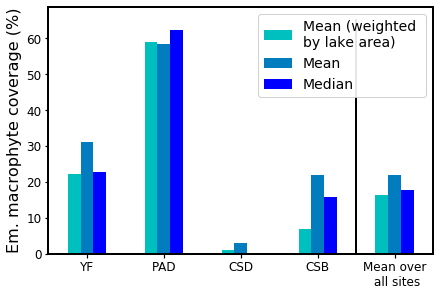

In [58]:
## Plot 4: Mean EM comparison with summary data
%matplotlib inline

# ## colors
# from cycler import cycler
# color_cycle = cycler(c=['r', 'g', 'b'])

fig4, ax4 = plt.subplots(constrained_layout=True) # constrained_layout is now default for presentation
# bar_heights=np.vstack((lakes_mean_df.em_weight_avg, lakes_mean_df.em_fractio))
# ax4.bar(np.arange(4), bar_heights, alpha=0.4, color='g')

lakes_mean_df_all12_summary_append.iloc[[3,2,1,0,7], ][['em_weight_avg', 'em_fractio', 'em_median']].plot.bar(ax=ax4, color = ['c', '#017CBF', 'b'])
# ax4.set_xlabel('Lake area ($km^2$)')
# ax4.set_ytick_labels([1,2])
# plt.setp(ax4.get_yticklabels(),labels=[1])
plt.gca().set_yticklabels([0,10,20,30,40,50,60]) # Sloopy fix!
ax4.set_xticks(np.arange(5))
labels=[label.split(' ')[0] for label in lakes_labels]
labels.append('Mean over\n all sites')
ax4.set_xticklabels(labels, rotation=0)
ax4.set_ylabel('Em. macrophyte coverage (%)')

## legend
ax4.legend(['Mean (weighted \nby lake area)','Mean','Median'])

## set ylim
ylims=ax4.get_ylim()
# ax4.set_ylim(ylims)

## add separator line
ax4.vlines(3.5, 0, ylims[1], linewidth = [plt.rcParams['axes.linewidth']])

## Save
figname=os.path.join(fig_dir, 'EM-mean-by-region-summary-min250-max34')
fig4.savefig(figname + '.jpg', dpi=300)
fig4.savefig(figname + '.pdf', dpi=300)

### Sanity check
Here, I calculate mean and median of merged dataframe with lakes from all four sites

In [13]:
print('Based on merged dataframe:\n')
print(f'Mean weighted by lake area (total): {np.average(lakes_all.em_fractio, weights=lakes_all.area_px_m2):0.3}')
print(f'Mean (total): {np.mean(lakes_all.em_fractio):0.3}')
print(f'\nSuper median (total): {np.median(lakes_all.em_fractio):0.3}')
print(f'10th percentile (total): {np.quantile(lakes_all.em_fractio, 0.1):0.3}')
print(f'90th percentile (total): {np.quantile(lakes_all.em_fractio, 0.9):0.3}')

Based on merged dataframe:

Mean weighted by lake area (total): 0.133
Mean (total): 0.204

Super median (total): 0.033
10th percentile (total): 0.0
90th percentile (total): 0.72


### More investigation On the distribution


Mean +/- stdev (%): 
[-8.44648167 49.17200478]

Quantiles (%): 
[ 0.5        72.49290345]

Mean +/- stdev on log transformed and undone (%): 
[ 0.55086118 33.54104526]


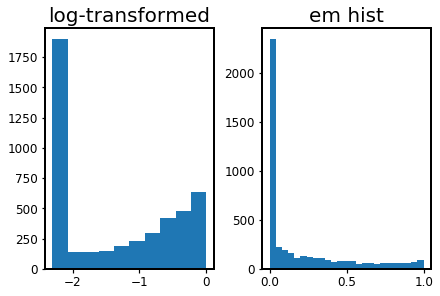

In [14]:
## More investigation On the distribution - from four cherry picked lakes
%matplotlib inline
# lakes_all.em_fractio.plot.hist()
em_transf = np.log10(lakes_all.em_fractio+0.005)
fig, ax = plt.subplots(1, 2)
ax[0].hist(em_transf); ax[0].set_title('log-transformed')
ax[1].hist(lakes_all.em_fractio, bins = 25); ax[1].set_title('em hist')

## mean +/- std
stddev = np.std(lakes_all.em_fractio)
print('\nMean +/- stdev (%): ')
print(100*np.array([lakes_all.em_fractio.mean()-stddev, lakes_all.em_fractio.mean()+stddev]))

## Verify that quantile's of log transformed data set are the same
print('\nQuantiles (%): ')
print(100*10**(np.quantile(em_transf, (0.1, 0.9))))

# Calculate standard deviation on log transformed data
stddev_log = np.std(em_transf)
print('\nMean +/- stdev on log transformed and undone (%): ')
print(100*10**np.array([em_transf.mean()-stddev_log, em_transf.mean()+stddev_log]))


Mean +/- stdev (%): 
[-1.44636256 49.17200478]

Quantiles (%): 
[ 0.5        79.47158021]

Mean +/- stdev on log transformed and undone (%): 
[ 1.16394036 59.51543753]


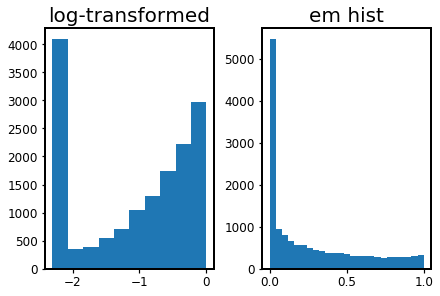

In [15]:
## More investigation On the distribution - average all 12, which is sketchy
%matplotlib inline
# lakes_all.em_fractio.plot.hist()
em_transf = np.log10(lakes_all_all12.em_fractio+0.005)
fig, ax = plt.subplots(1, 2)
ax[0].hist(em_transf); ax[0].set_title('log-transformed')
ax[1].hist(lakes_all_all12.em_fractio, bins = 25); ax[1].set_title('em hist')

## mean +/- std
stddev = np.std(lakes_all.em_fractio)
print('\nMean +/- stdev (%): ')
print(100*np.array([lakes_all_all12.em_fractio.mean()-stddev, lakes_all.em_fractio.mean()+stddev]))

## Verify that quantile's of log transformed data set are the same
print('\nQuantiles (%): ')
print(100*10**(np.quantile(em_transf, (0.1, 0.9))))

# Calculate standard deviation on log transformed data
stddev_log = np.std(em_transf)
print('\nMean +/- stdev on log transformed and undone (%): ')
print(100*10**np.array([em_transf.mean()-stddev_log, em_transf.mean()+stddev_log]))

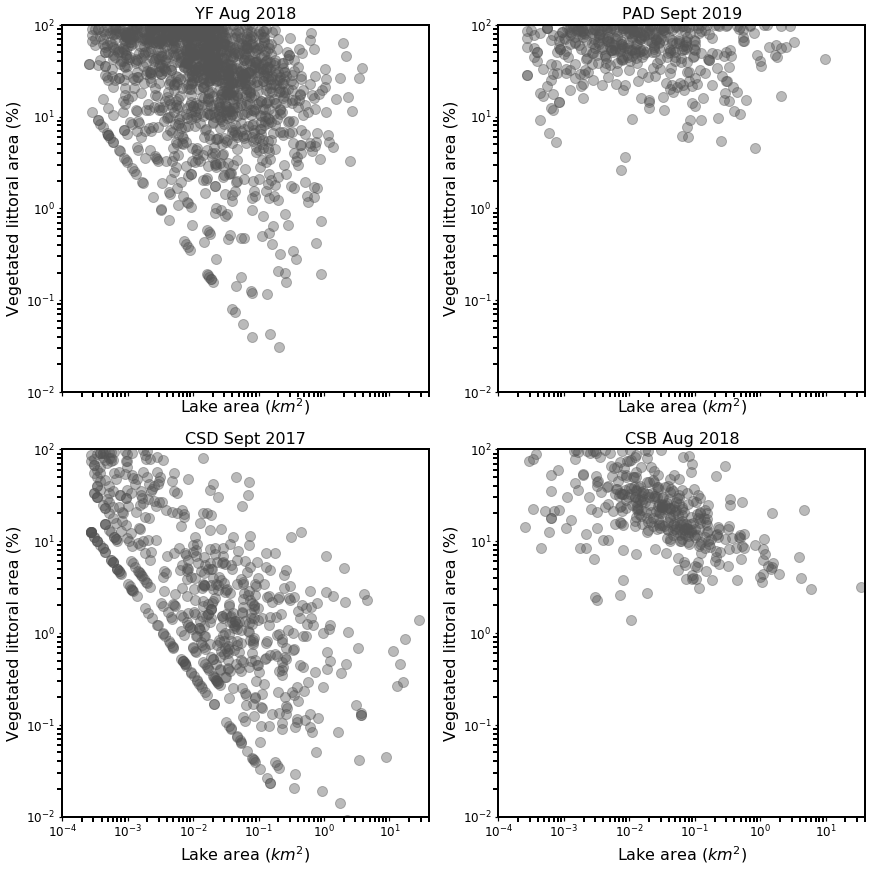

In [9]:
## Fig 5/S.3: A vs EM scatter plots!
## Run after first 8 cells to skip to here.

%matplotlib inline
from scipy.stats import pearsonr, spearmanr, linregress # spearman doesn't assume linearity

fig5, ax5 = plt.subplots(2,2, sharex=True, figsize=(12,12), constrained_layout=True) # constrained_layout is now default for presentation
color= '#545454' #fec89a'
for i, lakes in enumerate(lakes_list):
    axi = np.take(ax5, i)
    axi.scatter(lakes.area_px_m2/1e6, lakes.em_fractio*100, alpha=0.4, color=color)
    axi.set_xlabel('Lake area ($km^2$)')
    axi.set_ylabel('Vegetated littoral area (%)')
    axi.set_yscale('log')
    axi.set_xscale('log')
    axi.set_title(f'{lakes_labels[i]}', fontsize=16)
    axi.tick_params(which='minor', length=5, width =2)
    axi.set
    
    ## regression model
#     reg = linregress(np.log10(lakes_all.area_px_m2), np.log10(lakes_all.em_fractio+0.001))
#     post = np.logspace(-4, 2, 20)
#     model = 10**(reg.slope*post + reg.intercept)
#     axi.plot(post, model, '-k')
    
    axi.set_xlim(1e-4, 4e1)
    axi.set_ylim(0.01, 100) # , max_area_to_plot

    ## save fig 5
figname=os.path.join(fig_dir, 'Area-EM-scatter-subplots-min250-max34')
fig5.savefig(figname + '.jpg', dpi=300)
fig5.savefig(figname + '.pdf', dpi=300)

Area: YF Aug 2018	r2: 0.0745
Area: PAD Sept 2019	r2: 0.00287
Area: CSD Sept 2017	r2: 0.483
Area: CSB Aug 2018	r2: 0.252


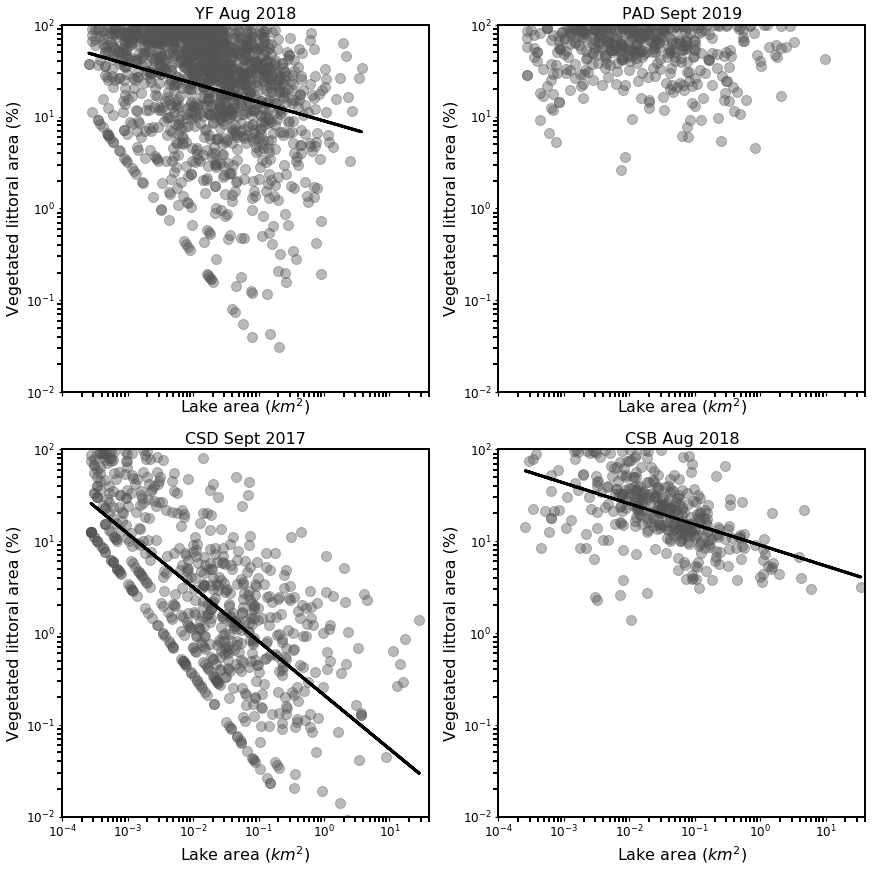

In [37]:
## V3 using log transforms in formula via statsmodels
## Fig 5/S.3: A vs EM scatter plots!
## Run after first 8 cells to skip to here.

%matplotlib inline
# from statsmodels.regression.linear_model import OLS
from statsmodels.formula.api import ols # from https://medium.com/swlh/log-transformations-in-linear-regression-the-basics-95bc79c1ad35
fig5, ax5 = plt.subplots(2,2, sharex=True, figsize=(12,12), constrained_layout=True) # constrained_layout is now default for presentation
color= '#545454' #fec89a'
for i, lakes in enumerate(lakes_list):
    axi = np.take(ax5, i)
    lakes['area_px_km2'] = lakes.area_px_m2/1e6
    lakes['em_fractio_per'] = lakes.em_fractio*100
    axi.scatter(lakes.area_px_km2, lakes.em_fractio_per, alpha=0.4, color=color)
    axi.set_xlabel('Lake area ($km^2$)')
    axi.set_ylabel('Vegetated littoral area (%)')
    axi.set_title(f'{lakes_labels[i]}', fontsize=16)
    axi.tick_params(which='minor', length=5, width =2)
    axi.set
    
    ## regression model
#     reg = linregress(np.log10(lakes.loc[lakes.em_fractio>0, 'area_px_m2']), np.log10(lakes.loc[lakes.em_fractio>0, 'em_fractio']+0))
#     post = np.linspace(-4, 5, 20)
#     model = reg.slope*post + reg.intercept
#     axi.plot(post, model, '-k')
#     print(reg)
    
    ## rm values with 0 EM to prevent log(0) warning
    lakes.drop(index=lakes[lakes.em_fractio==0].index, inplace=True)
    
    ## regression using statsmodels

    formula = 'np.log10(em_fractio_per)' + '~' + 'np.log10(area_px_km2)'
    model = ols(formula=formula, data=lakes).fit()
    print(f'Area: {lakes_labels[i]}\tr2: {model.rsquared:0.3}')
    if model.pvalues[1] < 0.001:
        y_pred = 10**(model.predict(lakes))
        axi.plot(lakes.area_px_km2, y_pred, 'k-', linewidth=3)
    axi.set_yscale('log')
    axi.set_xscale('log')
    axi.set_xlim(1e-4, 4e1)
    axi.set_ylim(0.01, 100) # , max_area_to_plot
    

    ## save fig 5
figname=os.path.join(fig_dir, 'Area-EM-scatter-subplots-min250-max34-regress')
fig5.savefig(figname + '.jpg', dpi=300)
fig5.savefig(figname + '.pdf', dpi=300)

In [8]:
## SCRAP
# reg
lakes[lakes.em_fractio>0].em_fractio
# np.log10(lakes.loc[lakes.area_px_m2>0, 'area_px_m2'])
model.summary()
# np.any(lakes.area_log==np.inf)
# lakes.area_log.min()
# lakes_list[0]
model.predict(lakes)  
# model.predict(model) 
model.params
model.summary()
model.rsquared

In [9]:
lakes_all.shape

(4572, 12)

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     np.log10(em_fractio_per)   R-squared:                       0.124
Model:                                  OLS   Adj. R-squared:                  0.124
Method:                       Least Squares   F-statistic:                     381.1
Date:                      Thu, 30 Sep 2021   Prob (F-statistic):           1.72e-79
Time:                              16:06:40   Log-Likelihood:                -2974.9
No. Observations:                      2694   AIC:                             5954.
Df Residuals:                          2692   BIC:                             5966.
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.5994      0.031     19.260      0.000       0.538       0.660
np.log10(area_px_km2)    -0.3094      0.016    -19.523      0.000      -0.340      -0.278
==============================================================================
Omnibus:                      399.443   Durbin-Watson:                   1.030
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              602.988
Skew:                          -1.062   Prob(JB):                    1.16e-131
Kurtosis:                       3.929   Cond. No.                         5.28
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

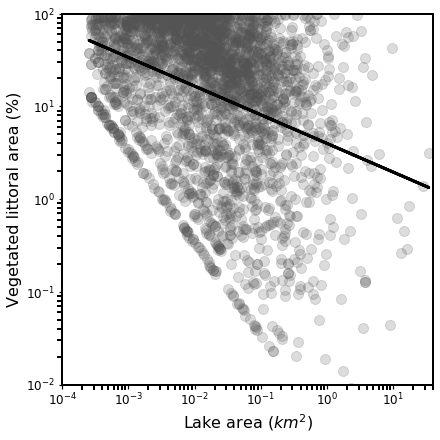

In [29]:
## Second plot
f=32 # font size for ASLO presentation
color= '#545454' #fec89a'
lakes_all['area_px_km2'] = lakes_all.area_px_m2/1e6
lakes_all['em_fractio_per'] = lakes_all.em_fractio*100
    
fig5b, ax5b = plt.subplots(figsize=(6,6), constrained_layout=True) # constrained_layout is now default for presentation
ax5b.scatter(lakes_all.area_px_km2, lakes_all.em_fractio_per, alpha=0.2, color=color)
ax5b.set_xlabel('Lake area ($km^2$)') #,  fontsize=f
ax5b.set_ylabel('Vegetated littoral area (%)') #, fontsize=f
ax5b.set_yscale('log')
ax5b.set_xscale('log')
ax5b.set_xlim(1e-4, 4e1) # , max_area_to_plot
ax5b.tick_params(which='minor', length=5, width =2)
ax5b.set_ylim(0.01, 100) # , max_area_to_plot

## rm values with 0 EM to prevent log(0) warning
lakes_all.drop(index=lakes_all[lakes_all.em_fractio==0].index, inplace=True)

## model
formula = 'np.log10(em_fractio_per)' + '~' + 'np.log10(area_px_km2)'
model = ols(formula=formula, data=lakes_all).fit()    
if model.pvalues[1] < 0.001:
    y_pred = 10**(model.predict(lakes_all))
    ax5b.plot(lakes_all.area_px_km2, y_pred, 'k-', linewidth=3)
display(model.summary())

# plt.setp(ax5b.get_xticklabels(), fontsize=f) # works
# ax5b.tick_params(labelsize=f-4)
# ax5b.

## save fig 5b
figname=os.path.join(fig_dir, 'Area-EM-scatter-all-min250-max34')
fig5b.savefig(figname + '.jpg', dpi=300)
fig5b.savefig(figname + '.pdf', dpi=300)

0
1
2
3


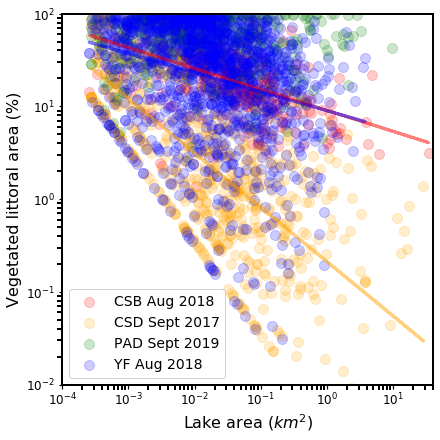

In [25]:
## Second plot v2: with colors
f=32 # font size for ASLO presentation
color = ['r','orange','g','b']
fig5b, ax5b = plt.subplots(figsize=(6,6), constrained_layout=True) # constrained_layout is now default for presentation
for i, lakes in enumerate(lakes_list[-1::-1]):
    print(i)
    ax5b.scatter(lakes.area_px_m2/1e6, lakes.em_fractio*100, alpha=0.2, color=color[i], label=lakes_labels[-1::-1][i])
    ax5b.set_xlabel('Lake area ($km^2$)') #,  fontsize=f
    ax5b.set_ylabel('Vegetated littoral area (%)') #, fontsize=f
    ax5b.set_yscale('log')
    ax5b.set_xscale('log')
    ax5b.set_xlim(1e-4, 4e1) # , max_area_to_plot
    ax5b.tick_params(which='minor', length=5, width =2)
    ax5b.set_ylim(0.01, 100) # , max_area_to_plot
    ax5b.legend()

     ## rm values with 0 EM to prevent log(0) warning
    lakes.drop(index=lakes[lakes.em_fractio==0].index, inplace=True)
    
    ## regression using statsmodels

    formula = 'np.log10(em_fractio_per)' + '~' + 'np.log10(area_px_km2)'
    model = ols(formula=formula, data=lakes).fit()    
    if model.pvalues[1] < 0.001:
        y_pred = 10**(model.predict(lakes))
        ax5b.plot(lakes.area_px_km2, y_pred, 'k-', linewidth=3, color=color[i], alpha=0.5)
        
    # save fig 5b temps
    figname=os.path.join(fig_dir, 'Area-EM-scatter-all-min250-max34-colors-'+lakes_labels[i])
    fig5b.savefig(figname + '.jpg', dpi=300)
    fig5b.savefig(figname + '.pdf', dpi=300)

## save fig 5b
figname=os.path.join(fig_dir, 'Area-EM-scatter-all-min250-max34-colors')
fig5b.savefig(figname + '.jpg', dpi=300)
fig5b.savefig(figname + '.pdf', dpi=300)

In [10]:
## correlation for this figure
from scipy.stats import pearsonr, spearmanr, linregress # spearman doesn't assume linearity
print('Numpy correlation is {:0.2}'.format(np.corrcoef(lakes_all.area_px_m2, lakes_all.em_fractio)[0,1]**2))
rp, pp = pearsonr(lakes_all.area_px_m2, lakes_all.em_fractio)
print('Pearson correlation is {:0.2} (p = {:0.3})'.format(rp**2, pp))
rs, ps = spearmanr(lakes_all.area_px_m2, lakes_all.em_fractio)
print('Spearman correlation is {:0.3} (p = {:0.3})'.format(rs**2, ps))
linregress(lakes_all.area_px_m2, lakes_all.em_fractio) #ls, li, lr, lp = 

Numpy correlation is 0.00099
Pearson correlation is 0.00099 (p = 0.0331)
Spearman correlation is 0.101 (p = 3.46e-108)


LinregressResult(slope=-1.0135849976594869e-08, intercept=0.2048013953302444, rvalue=-0.03150635196342392, pvalue=0.033147048937501554, stderr=4.756508697231781e-09)

In [13]:
## correlation for each subfigure above
for i, lakes in enumerate(lakes_list):
    rs, ps = spearmanr(lakes.area_px_m2, lakes.em_fractio)
    rp, pp = pearsonr(lakes.area_px_m2, lakes.em_fractio)
    print('{}: Spearman correlation is {:0.3}\t(p = {:0.3})\t||\tPearson: {:0.3} \t(p = {:0.3})'.format(lakes_labels[i], rs**2, ps, rp, pp))

YF Aug 2018: Spearman correlation is 0.0687	(p = 2.1e-29)	||	Pearson: -0.0572 	(p = 0.0158)
PAD Sept 2019: Spearman correlation is 0.00155	(p = 0.412)	||	Pearson: -0.00974 	(p = 0.839)
CSD Sept 2017: Spearman correlation is 0.0819	(p = 1.61e-38)	||	Pearson: -0.0278 	(p = 0.216)
CSB Aug 2018: Spearman correlation is 0.183	(p = 3.51e-18)	||	Pearson: -0.107 	(p = 0.0374)


In [21]:
## Top n lakes calculation
for k in [5, 10, 50, 100, 500]:
    # total area in top 50 lakes 
    a_lake_top50 = lakes_all.sort_values('area_px_m2').area_px_m2.tail(k).sum()/1e6

    # total em area in top 50 lakes
    a_em_top50 = np.sum(lakes_all.sort_values('area_px_m2').area_px_m2.tail(k) * lakes_all.sort_values('area_px_m2').em_fractio.tail(50))/1e6

    # total EM area
    a_em_tot = np.sum(lakes_all.sort_values('area_px_m2').area_px_m2*lakes_all.sort_values('area_px_m2').em_fractio)/1e6

    # total lake area
    a_lake_tot = lakes_all.area_px_m2.sum()/1e6

    print(f'The top {k} lakes hold {a_lake_top50/a_lake_tot:.1%} of the total lake area and {a_em_top50/a_em_tot:.1%} of the total EM area.')

## What size?
# lakes_all.sort_values('area_px_m2').area_px_m2[-100:-99]/1e6

The top 5 lakes hold 20.9% of the total lake area and 2.5% of the total EM area.
The top 10 lakes hold 30.2% of the total lake area and 8.7% of the total EM area.
The top 50 lakes hold 51.3% of the total lake area and 35.3% of the total EM area.
The top 100 lakes hold 62.5% of the total lake area and 35.3% of the total EM area.
The top 500 lakes hold 86.1% of the total lake area and 35.3% of the total EM area.


In [38]:
## AREA BINS
print(groups_all4.count())

                     label  area_px_m2  perimeter_  em_fractio  fw_fractio  \
area_px_m2                                                                   
(0.00025, 0.000409]    455         455         455         455         455   
(0.000409, 0.00067]    432         432         432         432         432   
(0.00067, 0.0011]      301         301         301         301         301   
(0.0011, 0.00179]      263         263         263         263         263   
(0.00179, 0.00294]     272         272         272         272         272   
(0.00294, 0.00481]     253         253         253         253         253   
(0.00481, 0.00787]     304         304         304         304         304   
(0.00787, 0.0129]      367         367         367         367         367   
(0.0129, 0.0211]       376         376         376         376         376   
(0.0211, 0.0345]       339         339         339         339         339   
(0.0345, 0.0565]       277         277         277         277  

In [37]:
## For statement:
'''In comparison, the Canadian Shield areas we sampled have greatest AVL in small-to-medium lakes 0.0001 - 0.002 km2 in area, with values ranging from 7.3 [4.5 – 10.7] % (CSD) to 55 [35 – 81] % (CSB). '''
print(lakes_labels)
# i=2 #CSD
i=3 #CSB
# groups_list[i].mean()
error_bars_list[i]

['YF Aug 2018', 'PAD Sept 2019', 'CSD Sept 2017', 'CSB Aug 2018']


array([[0.22472222, 0.09460882, 0.14648885, 0.18978834, 0.17565925,
        0.14167424, 0.09741851, 0.07120984, 0.05962923, 0.04211793,
        0.03179028, 0.05421864, 0.02514617, 0.02978257, 0.09023698,
        0.02327309, 0.01990668, 0.01922758,        nan, 0.06955949,
               nan,        nan,        nan,        nan],
       [0.23802778, 0.09113465, 0.17215942, 0.19932274, 0.21109755,
        0.13268565, 0.09026417, 0.06583799, 0.06923385, 0.0372364 ,
        0.0296405 , 0.05258969, 0.03132351, 0.03332944, 0.13173628,
        0.03736939, 0.03494604, 0.02940019,        nan, 0.06015334,
               nan,        nan,        nan,        nan]])

## Archive

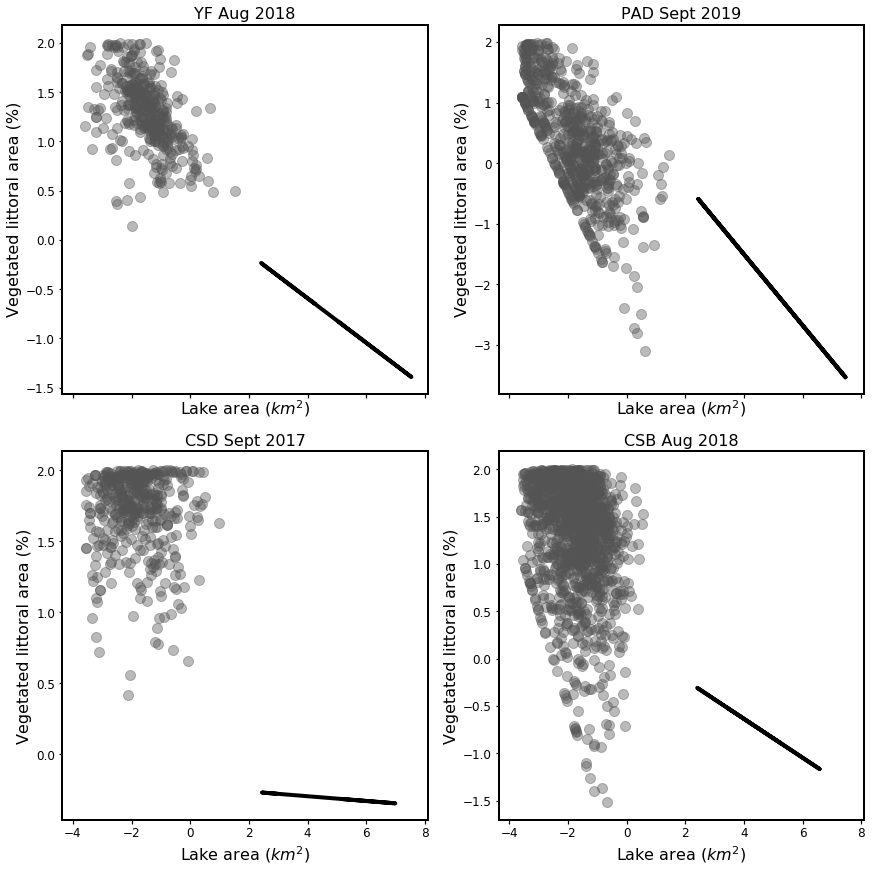

In [138]:
## V2 using log transforms...
## Fig 5/S.3: A vs EM scatter plots!
## Run after first 8 cells to skip to here.

%matplotlib inline
# from statsmodels.regression.linear_model import OLS
from statsmodels.formula.api import ols # from https://medium.com/swlh/log-transformations-in-linear-regression-the-basics-95bc79c1ad35
fig5, ax5 = plt.subplots(2,2, sharex=True, figsize=(12,12), constrained_layout=True) # constrained_layout is now default for presentation
color= '#545454' #fec89a'
for i, lakes in enumerate(lakes_list):
    axi = np.take(ax5, i)
    axi.scatter(np.log10(lakes.area_px_m2/1e6), np.log10(lakes.em_fractio*100+0), alpha=0.4, color=color)
    axi.set_xlabel('Lake area ($km^2$)')
    axi.set_ylabel('Vegetated littoral area (%)')
#     axi.set_yscale('log')
#     axi.set_xscale('log')
    axi.set_title(f'{lakes_labels[i]}', fontsize=16)
    axi.tick_params(which='minor', length=5, width =2)
    axi.set
    
    ## regression model
#     reg = linregress(np.log10(lakes.loc[lakes.em_fractio>0, 'area_px_m2']), np.log10(lakes.loc[lakes.em_fractio>0, 'em_fractio']+0))
#     post = np.linspace(-4, 5, 20)
#     model = reg.slope*post + reg.intercept
#     axi.plot(post, model, '-k')
#     print(reg)
    
    ## rm values with 0 EM to prevent log(0) warning
    lakes.drop(index=lakes[lakes.em_fractio==0].index, inplace=True)
    
    ## regression using statsmodels
    lakes['area_log'] = np.log10(lakes['area_px_m2'])
    lakes['avl_log'] = np.log10(lakes['em_fractio'])
    formula = 'avl_log' + '~' + 'area_log'
    model = ols(formula=formula, data=lakes).fit()
#     model.summary()
    y_pred = model.predict(lakes)    
    axi.plot(lakes.area_log, y_pred, 'k-')
#     axi.set_xlim(-4, 1)
#     axi.set_ylim(-3, 2.3) # , max_area_to_plot

    ## save fig 5
figname=os.path.join(fig_dir, 'Area-EM-scatter-subplots-min250-max34-regress')
fig5.savefig(figname + '.jpg', dpi=300)
fig5.savefig(figname + '.pdf', dpi=300)

In [12]:
## Fig 1: EM hist plot
%matplotlib widget
fig, ax = plt.subplots(2,2, sharex=True, figsize=(12,12), constrained_layout=True) # constrained_layout is now default for presentation

for i, lakes in enumerate(lakes_list):
    
    ## prep
    axi = np.take(ax, i)
    h=axi.hist(lakes.em_fractio, alpha=0.4, color='b', label=label, bins=bins/max_area_to_plot)
    axi.set_ylabel('Lake count')
    axi.set_xlabel('Emergent macrophyte fraction')
    axi.set_title(f'{lakes_labels[i]}\nLakes > {min_size} m2 ({min_size/px_area:.0f} px)', fontsize=16)
    
## save fig 1
figname=os.path.join(fig_dir, 'Hists-subplots-min250-max34')
fig.savefig(figname + '.jpg', dpi=300)
fig.savefig(figname + '.pdf', dpi=300)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [13]:
## Fig 2: Hist plot by area (linear x scale)
%matplotlib widget
fig2, ax2 = plt.subplots(2,2, sharex=False, figsize=(12,12), constrained_layout=True) # constrained_layout is now default for presentation
for i, lakes in enumerate(lakes_list):
    axi = np.take(ax2, i)
    area_bins_lin=pd.cut(lakes.area_px_m2/1e6, bins)
    groups_lin=lakes.groupby(area_bins_lin)
#     h=groups.mean().em_fractio.plot.bar(ax=axi, width=1, color='c')
#     bar_locs = [groups.mean().em_fractio.index[j].mid for j in range(len(groups))]
    axi.bar(bins[:-1], groups_lin.mean().em_fractio, color='c', align='edge', width=np.diff(bins)) # width=1,  width=0.2
    axi.set_xlabel('Lake area ($km^2$)')
    axi.set_ylabel('Mean emergent macrophyte fraction')
    axi.set_title(f'{lakes_labels[i]}', fontsize=16)
    # axi.set_xticks(np.arange(0,7,1))
    # axi.set_xticks(axi.get_xticks()[0:nbins+6:nbins//6])
    # axi.set_xticks(np.arange(0,7,1))
    # axi.set_xticklabels([f'{i:.1f}' for i in bins[0:nbins+6:nbins//6]], rotation = 0) # match default histogram formatting
#     axi.set_xscale('linear')
#     axi.set_xticks(np.arange(0,nMajorTicks,1)/nMajorTicks*25)
#     axi.set_xticklabels(np.arange(0,nMajorTicks,1), rotation = 0) # match default histogram formatting
    
## save fig 2: by area
figname=os.path.join(fig_dir, 'Hists-by-area-subplots-min250-max34')
fig2.savefig(figname + '.jpg', dpi=300)
fig2.savefig(figname + '.pdf', dpi=300)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [32]:
## Fig 2b: Hist plot by area (logx)
%matplotlib widget
fig2, ax2 = plt.subplots(2,2, sharex=True, figsize=(12,12), constrained_layout=True) # constrained_layout is now default for presentation
for i, lakes in enumerate(lakes_list):
    axi = np.take(ax2, i)
    area_bins=area_bins_list[i]
    groups=groups_list[i]
#     h=groups.mean().em_fractio.plot.bar(ax=axi, width=1, color='c')
#     bar_locs = [groups.mean().em_fractio.index[j].mid for j in range(len(groups))]
    axi.bar(bins_log[:-1], groups.mean().em_fractio, color='c', align='edge', width=np.diff(bins_log)) # width=1,  width=0.2
    axi.set_xlabel('Lake area ($km^2$)')
    axi.set_ylabel('Mean emergent macrophyte fraction')
    axi.set_title(f'{lakes_labels[i]}', fontsize=16)
    # axi.set_xticks(np.arange(0,7,1))
    # axi.set_xticks(axi.get_xticks()[0:nbins+6:nbins//6])
    # axi.set_xticks(np.arange(0,7,1))
    # axi.set_xticklabels([f'{i:.1f}' for i in bins[0:nbins+6:nbins//6]], rotation = 0) # match default histogram formatting
    axi.set_xscale('log')
#     axi.set_xticks(np.arange(0,nMajorTicks,1)/nMajorTicks*25)
#     axi.set_xticklabels(np.arange(0,nMajorTicks,1), rotation = 0) # match default histogram formatting
    
## save fig 2: by area
figname=os.path.join(fig_dir, 'Hists-by-area-subplots-logx-min250-max34')
fig2.savefig(figname + '.jpg', dpi=300)
fig2.savefig(figname + '.pdf', dpi=300)

## save xlims for next plot to make it a tapper
xlims=axi.get_xlim()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [114]:
## Fig 2d: Hist plot by area with summed bins(logx)
%matplotlib widget
color_em_littoral = '#58D918'
fig2, ax2 = plt.subplots(2,2, sharex=True, figsize=(12,12), constrained_layout=True) # constrained_layout is now default for presentation
for i, lakes in enumerate(lakes_list):
    axi = np.take(ax2, i)
    area_bins=area_bins_list[i]
    groups=groups_list[i]
    error_bars = error_bars_list[i]
#     yerr = groups.em_fractio.quantile(0.25) #groups.std().em_fractio #.to_numpy()  #np.vstack((groups.std().em_fractio.to_numpy(), groups.std().em_fractio.to_numpy())).T # MEMORY CRASH HERE... ???
    h=axi.bar(bins_log[:-1], groups.mean().em_fractio * groups.sum().area_px_m2/1e6, color=color_em_littoral,\
              align='edge', width=np.diff(bins_log), label='Emerg. Macr. Area')#, yerr=confidence) # width=1,  width=0.2 , conf_intervals=confidence
    axi.set_xlabel('Lake area ($km^2$)')
    axi.set_ylabel('Total littoral emergent macrophyte area ($km^2$)')
    
    ## y axis 2
    axiyy=axi.twinx()
    h1=axiyy.hist(lakes.area_px_m2/1e6, alpha=0.1, color='black', bins=bins_log, label='Area histogram') # , histtype='step'
#     axiyy.set_yticklabels([axiyy.get_yticklabels()[i].get_text() for i in range(len(axiyy.get_yticklabels()))], color='b')
    for j in range(len(axiyy.get_yticklabels())): # clunky way to set color
        axiyy.get_yticklabels()[j].set_color((0.6, 0.6, 0.6))   
    axiyy.set_ylabel('Count')
    axiyy.yaxis.label.set_color((0.6, 0.6, 0.6))
    axi.set_title(f'{lakes_labels[i]} (n = {lakes.em_fractio.count()})', fontsize=16)
    axi.set_xscale('log')
    axi.set_xlim(xlims)

## legend on one plot only
# handles, labels = axi.get_legend_handles_labels()
# handlesyy, labelsyy = axiyy.get_legend_handles_labels() # doesn't work
import matplotlib.patches as mpatches
handlesyy = mpatches.Patch(color='black', label='Area histogram', alpha=0.1)
handles = mpatches.Patch(color=color_em_littoral, label='Area histogram') # 'c'
ax2[1,0].legend([handles, handlesyy], ['Emerg. Macr. Area', 'Area histogram'])
plt.legend

## Second plot
fig, ax = plt.subplots(figsize=(6,6), constrained_layout=True) # constrained_layout is now default for presentation
#     yerr = groups.em_fractio.quantile(0.25) #groups.std().em_fractio #.to_numpy()  #np.vstack((groups.std().em_fractio.to_numpy(), groups.std().em_fractio.to_numpy())).T # MEMORY CRASH HERE... ???
h=ax.bar(bins_log[:-1], groups_all4.mean().em_fractio * groups_all4.sum().area_px_m2/1e6, color=color_em_littoral,\
          align='edge', width=np.diff(bins_log), label='EM fraction')#, yerr=confidence) # width=1,  width=0.2 , conf_intervals=confidence # 'c'
ax.set_xlabel('Lake area ($km^2$)')
ax.set_ylabel('Total littoral emergent macrophyte area ($km^2$)')

## y axis 2
axiyyb=ax.twinx()
h1=axiyyb.hist(lakes_all.area_px_m2/1e6, alpha=0.1, color='black', bins=bins_log, label='Area histogram') # , histtype='step'
#     axiyy.set_yticklabels([axiyy.get_yticklabels()[i].get_text() for i in range(len(axiyy.get_yticklabels()))], color='b')
for j in range(len(axiyyb.get_yticklabels())): # clunky way to set color
    axiyyb.get_yticklabels()[j].set_color((0.6, 0.6, 0.6))   
axiyyb.set_ylabel('Count')
axiyyb.yaxis.label.set_color((0.6, 0.6, 0.6))
ax.set_title(f'All (n={len(lakes_all)})', fontsize=16)
ax.set_xscale('log')
ax.set_xlim(xlims)

## save fig 2c: by area
figname=os.path.join(fig_dir, 'Hists-by-area-binsum-subplots-logx-with-area-hists-min250-max34')
fig2.savefig(figname + '.jpg', dpi=300)
fig2.savefig(figname + '.pdf', dpi=300)

## save fig 2cb: by area
figname=os.path.join(fig_dir, 'Hists-by-area-binsum-all-logx-with-area-hists-min250-max34')
fig.savefig(figname + '.jpg', dpi=300)
fig.savefig(figname + '.pdf', dpi=300)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [115]:
## Fig 2e: Hist plot by area with summed bins and summed area hist bins (logx)
color_em_littoral = '#58D918'
%matplotlib widget
fig2, ax2 = plt.subplots(2,2, sharex=True, figsize=(12,12), constrained_layout=True) # constrained_layout is now default for presentation
for i, lakes in enumerate(lakes_list):
    axi = np.take(ax2, i)
    area_bins=area_bins_list[i]
    groups=groups_list[i]
    error_bars = error_bars_list[i]
#     yerr = groups.em_fractio.quantile(0.25) #groups.std().em_fractio #.to_numpy()  #np.vstack((groups.std().em_fractio.to_numpy(), groups.std().em_fractio.to_numpy())).T # MEMORY CRASH HERE... ???
    h=axi.bar(bins_log[:-1], groups.mean().em_fractio * groups.sum().area_px_m2/1e6, color=color_em_littoral,\
              align='edge', width=np.diff(bins_log), label='Emerg. Macr. Area')#, yerr=confidence) # width=1,  width=0.2 , conf_intervals=confidence
    axi.set_xlabel('Lake area ($km^2$)')
    axi.set_ylabel('Total littoral emergent macrophyte area ($km^2$)')
    
    ## y axis 2
    axiyy=axi.twinx()
    h1=axiyy.bar(bins_log[:-1], groups.sum().area_px_m2/1e6, alpha = 0.1, color='black',\
              align='edge', width=np.diff(bins_log), label='Total lake area/bin') 
    for j in range(len(axiyy.get_yticklabels())): # clunky way to set color
        axiyy.get_yticklabels()[j].set_color((0.6, 0.6, 0.6))   
    axiyy.set_ylabel('Lake area ($km^2$)')
    axiyy.yaxis.label.set_color((0.6, 0.6, 0.6))
    axi.set_title(f'{lakes_labels[i]} (n = {lakes.em_fractio.count()})', fontsize=16)
    axi.set_xscale('log')
    axi.set_xlim(xlims)

## legend on one plot only
# handles, labels = axi.get_legend_handles_labels()
# handlesyy, labelsyy = axiyy.get_legend_handles_labels() # doesn't work
import matplotlib.patches as mpatches
handlesyy = mpatches.Patch(color='black', label='Total lake area/bin', alpha=0.1)
handles = mpatches.Patch(color=color_em_littoral, label='Area histogram') # 'c'
ax2[1,0].legend([handles, handlesyy], ['Emerg. Macr. Area', 'Total lake area/bin'])
plt.legend

## Second plot
fig, ax = plt.subplots(figsize=(6,6), constrained_layout=True) # constrained_layout is now default for presentation
#     yerr = groups.em_fractio.quantile(0.25) #groups.std().em_fractio #.to_numpy()  #np.vstack((groups.std().em_fractio.to_numpy(), groups.std().em_fractio.to_numpy())).T # MEMORY CRASH HERE... ???
h=ax.bar(bins_log[:-1], groups_all4.mean().em_fractio * groups_all4.sum().area_px_m2/1e6, color=color_em_littoral,\
          align='edge', width=np.diff(bins_log), label='EM fraction')
ax.set_xlabel('Lake area ($km^2$)')
ax.set_ylabel('Total littoral emergent macrophyte area ($km^2$)')

## y axis 2
axiyyb=ax.twinx()
h1=axiyyb.bar(bins_log[:-1], groups.sum().area_px_m2/1e6, alpha = 0.1, color='black',\
              align='edge', width=np.diff(bins_log), label='Total lake area/bin') 
for j in range(len(axiyyb.get_yticklabels())): # clunky way to set color
    axiyyb.get_yticklabels()[j].set_color((0.6, 0.6, 0.6))   
axiyyb.set_ylabel('Lake area ($km^2$)')
axiyyb.yaxis.label.set_color((0.6, 0.6, 0.6))
ax.set_title(f'All (n={len(lakes_all)})', fontsize=16)
ax.set_xscale('log')
ax.set_xlim(xlims)

## save fig 2c: by area
figname=os.path.join(fig_dir, 'Hists-by-area-binsum-subplots-logx-with-area-hists-sum-min250-max34')
fig2.savefig(figname + '.jpg', dpi=300)
fig2.savefig(figname + '.pdf', dpi=300)

## save fig 2cb: by area
figname=os.path.join(fig_dir, 'Hists-by-area-binsum-all-logx-with-area-hists-sum-min250-max34')
fig.savefig(figname + '.jpg', dpi=300)
fig.savefig(figname + '.pdf', dpi=300)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

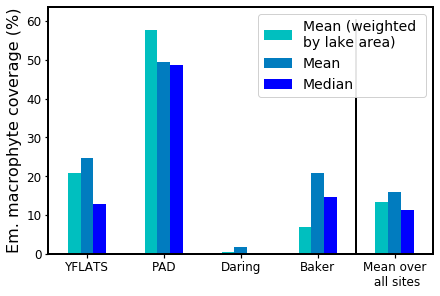

In [245]:
## Plot 4: Mean EM comparison on 4 key dates
%matplotlib inline

# ## colors
# from cycler import cycler
# color_cycle = cycler(c=['r', 'g', 'b'])

fig4, ax4 = plt.subplots(constrained_layout=True) # constrained_layout is now default for presentation
# bar_heights=np.vstack((lakes_mean_df.em_weight_avg, lakes_mean_df.em_fractio))
# ax4.bar(np.arange(4), bar_heights, alpha=0.4, color='g')

lakes_mean_df_append.iloc[[0,1,2,3,7], :][['em_weight_avg', 'em_fractio', 'em_median']].plot.bar(ax=ax4, color = ['c', '#017CBF', 'b'])
# ax4.set_xlabel('Lake area ($km^2$)')
# ax4.set_ytick_labels([1,2])
# plt.setp(ax4.get_yticklabels(),labels=[1])
plt.gca().set_yticklabels([0,10,20,30,40,50,60]) # Sloopy fix!
ax4.set_xticks(np.arange(5))
labels=[label.split(' ')[0] for label in lakes_labels]
labels.append('Mean over\n all sites')
ax4.set_xticklabels(labels, rotation=0)
ax4.set_ylabel('Em. macrophyte coverage (%)')

## legend
ax4.legend(['Mean (weighted \nby lake area)','Mean','Median'])

## set ylim
ylims=ax4.get_ylim()
# ax4.set_ylim(ylims)

## add separator line
ax4.vlines(3.5, 0, ylims[1], linewidth = [plt.rcParams['axes.linewidth']])

## Save
figname=os.path.join(fig_dir, 'EM-mean-by-region-min250-max34')
fig4.savefig(figname + '.jpg', dpi=300)
fig4.savefig(figname + '.pdf', dpi=300)

# SCRAP

In [28]:
## Add median! [only median of 4 vals...hm]
lakes_mean_df_med = pd.DataFrame(np.median(lakes_mean_df, axis=0)).T
lakes_mean_df_med.columns=lakes_mean_df.columns
lakes_mean_df_med
# lakes_mean_df

,label,area_px_m2,perimeter_,em_fractio,fw_fractio,sw_fractio,gw_fractio,edge,cir_observ,em_weight_avg,Count,em_median
0,13645.266497,156961.391675,2039.250772,0.228495,0.000282,0.043361,0.183756,0.0,1.0,0.139299,1034.5,0.137357


In [152]:
## SCRAP

# lakes_mean_df_append = lakes_mean_df.append(pd.DataFrame(lakes_mean_df.sum()))
# lakes_mean_df_append
([label.split(' ')[0] for label in lakes_labels]).append('All')
labels
ax4.get_xticks()
type(plt.rcParams['axes.linewidth'])
# pd.DataFrame(np.average(lakes_mean_df, weights=lakes_mean_df.Count, axis=0), columns=lakes_mean_df.columns).T #.rename('All')
pd.DataFrame(lakes_mean_df_append[0:-1].mean()).T

,label,area_px_m2,perimeter_,em_fractio,fw_fractio,sw_fractio,gw_fractio,edge,cir_observ,em_weight_avg,Count
0,14011.95083,170707.944513,2364.077686,0.255063,0.000807,0.090582,0.163675,0.0,1.0,0.215413,926.5


In [147]:
## SCRAP

lakes_mean_df
# lakes_mean_df.Count
lakes_mean_df_append

,label,area_px_m2,perimeter_,em_fractio,fw_fractio,sw_fractio,gw_fractio,edge,cir_observ,em_weight_avg,Count
YFLATS Aug 2018,21299.988932,74557.758431,1474.388578,0.266629,0.002637,0.054272,0.209721,0.0,1.0,0.209361,1536.000000
PAD Sept 2019,10954.664962,170682.978758,3619.403251,0.523086,0.000237,0.271563,0.251286,0.0,1.0,0.577378,391.000000
Daring Sept 2017,16321.135689,182193.575047,1688.450060,0.019698,0.000000,0.000250,0.019448,0.0,1.0,0.005612,1415.000000
Baker Aug 2018,7472.013736,255397.465814,2674.068853,0.210840,0.000353,0.036241,0.174245,0.0,1.0,0.069302,364.000000
0,16949.346195,143558.107904,1900.260503,0.193926,0.001153,0.054800,0.137973,0.0,1.0,0.156638,1253.885051


In [28]:
%matplotlib widget
lakes.em_fractio*100
# plt.scatter(lakes.area_px_m2/1e6, lakes.em_fractio*100, alpha=0.4, color='g')

18      26.046512
21      34.732824
27      18.165468
31      10.378117
35      11.734694
          ...    
1319    19.731650
1320    87.767584
1335    31.154239
1346    32.586786
1347    23.969319
Name: em_fractio, Length: 364, dtype: float64

# Scrap

In [111]:
## Fig 2: Hist plot by area (linear x scale) # old version using object.plt.bar, not plt.bar(...)
%matplotlib widget
fig2, ax2 = plt.subplots(2,2, sharex=True, figsize=(12,12), constrained_layout=True) # constrained_layout is now default for presentation
for i, lakes in enumerate(lakes_list):
    axi = np.take(ax2, i)
    area_bins=pd.cut(lakes.area_px_m2/1e6, bins)
    groups=lakes.groupby(area_bins)
    h=groups.mean().em_fractio.plot.bar(ax=axi, width=1, color='c')
#     bar_locs = [groups.mean().em_fractio.index[j].mid for j in range(len(groups))]
#     axi.bar(bar_locs, groups.mean().em_fractio, color='c') # width=1, 
    axi.set_xlabel('Lake area ($km^2$)')
    axi.set_ylabel('Mean emergent macrophyte fraction')
    axi.set_title(f'{lakes_labels[i]}', fontsize=16)
    # axi.set_xticks(np.arange(0,7,1))
    # axi.set_xticks(axi.get_xticks()[0:nbins+6:nbins//6])
    # axi.set_xticks(np.arange(0,7,1))
    # axi.set_xticklabels([f'{i:.1f}' for i in bins[0:nbins+6:nbins//6]], rotation = 0) # match default histogram formatting
#     axi.set_xscale('linear')
    axi.set_xticks(np.arange(0,nMajorTicks,1)/nMajorTicks*25)
    axi.set_xticklabels(np.arange(0,nMajorTicks,1), rotation = 0) # match default histogram formatting
    
## save fig 2: by area
figname=os.path.join(fig_dir, 'Hists-by-area-subplots')
fig2.savefig(figname + '.jpg', dpi=300)
fig2.savefig(figname + '.pdf', dpi=300)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [124]:
dir(h)
# h.get_xticks()
print(groups.mean().em_fractio)
print(bar_locs)
print(np.diff(bar_locs)) # not evenlyspaced!
lakes_labels[i]
bins
bins[:-1]

area_px_m2
(0.0, 0.208]      0.227983
(0.208, 0.417]    0.152340
(0.417, 0.625]    0.083529
(0.625, 0.833]    0.073672
(0.833, 1.042]    0.057883
(1.042, 1.25]     0.049353
(1.25, 1.458]     0.030674
(1.458, 1.667]    0.089811
(1.667, 1.875]         NaN
(1.875, 2.083]    0.025910
(2.083, 2.292]         NaN
(2.292, 2.5]           NaN
(2.5, 2.708]           NaN
(2.708, 2.917]         NaN
(2.917, 3.125]    0.044272
(3.125, 3.333]         NaN
(3.333, 3.542]         NaN
(3.542, 3.75]          NaN
(3.75, 3.958]          NaN
(3.958, 4.167]    0.027551
(4.167, 4.375]         NaN
(4.375, 4.583]         NaN
(4.583, 4.792]    0.201960
(4.792, 5.0]           NaN
Name: em_fractio, dtype: float64
[0.104, 0.3125, 0.521, 0.729, 0.9375, 1.146, 1.354, 1.5625, 1.771, 1.979, 2.1875, 2.396, 2.604, 2.8125, 3.021, 3.229, 3.4375, 3.646, 3.854, 4.0625, 4.271, 4.479, 4.6875, 4.896]
[0.2085 0.2085 0.208  0.2085 0.2085 0.208  0.2085 0.2085 0.208  0.2085
 0.2085 0.208  0.2085 0.2085 0.208  0.2085 0.2085 0.208  0.2

array([0.        , 0.20833333, 0.41666667, 0.625     , 0.83333333,
       1.04166667, 1.25      , 1.45833333, 1.66666667, 1.875     ,
       2.08333333, 2.29166667, 2.5       , 2.70833333, 2.91666667,
       3.125     , 3.33333333, 3.54166667, 3.75      , 3.95833333,
       4.16666667, 4.375     , 4.58333333, 4.79166667])